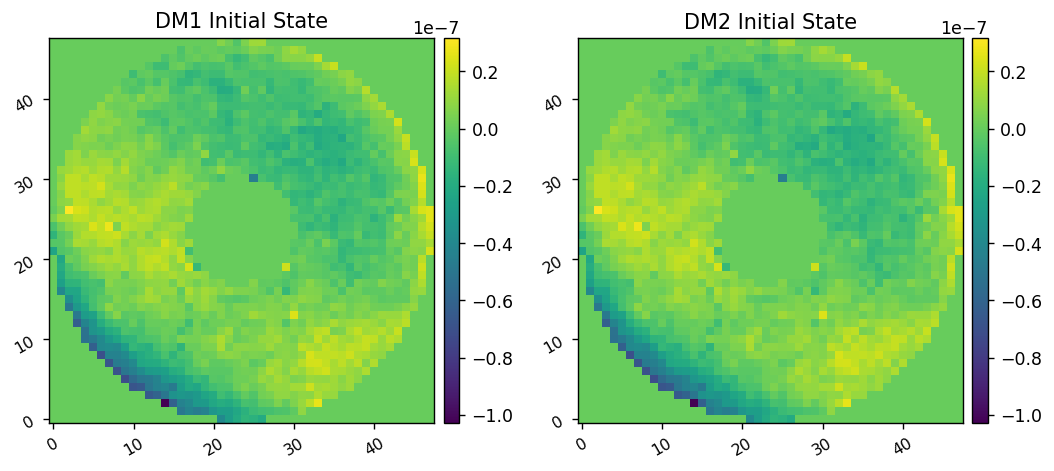

In [3]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

# import wfsc_tests as wfsc
# wfsc.math_module.update_np(cp)
# wfsc.math_module.update_scipy(cupyx.scipy)
# from wfsc_tests.math_module import xp, _scipy, ensure_np_array

import cgi_phasec_poppy

from math_module import xp
import iefc_2dm 
import utils
from imshows import *

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
# iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

imshow2(dm1_flat/2, dm2_flat/2, 'DM1 Initial State', 'DM2 Initial State', cmap1='viridis', cmap2='viridis')

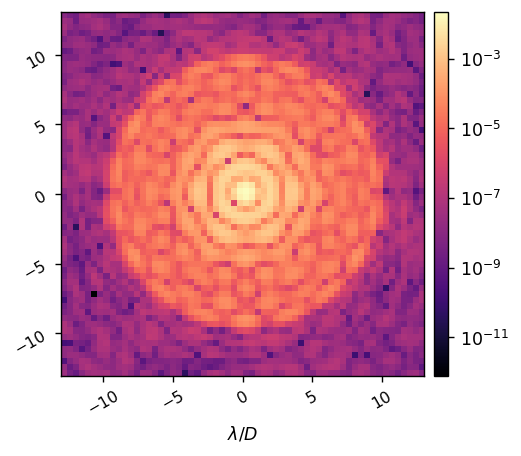

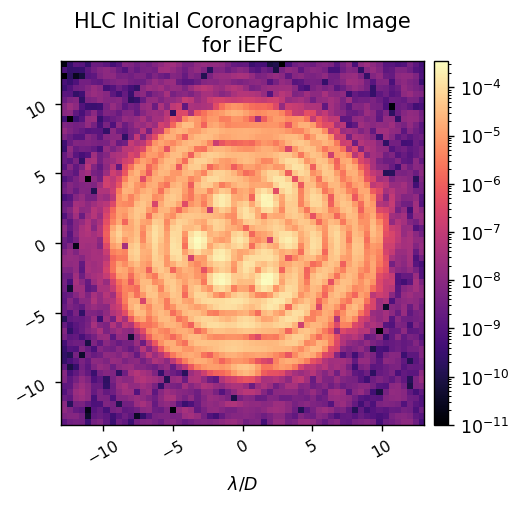

In [4]:
reload(cgi)
c = cgi_phasec_poppy.cgi.CGI(cgi_mode='hlc', npsf=60,
                              use_pupil_defocus=True, 
                              use_opds=True)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

c.use_fpm = False
ref_unocc_im = c.snap()
imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

c.Imax_ref = ref_unocc_im.get().max()
c.use_fpm = True

ref_im = c.snap()
imshow1(ref_im, 'HLC Initial Coronagraphic Image\nfor iEFC',
        pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

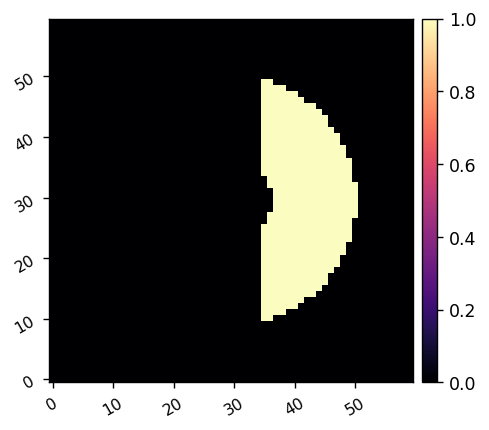

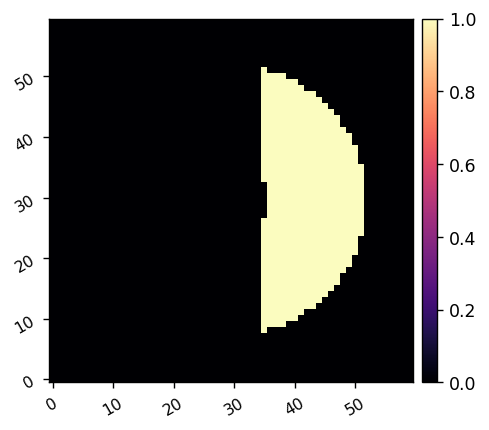

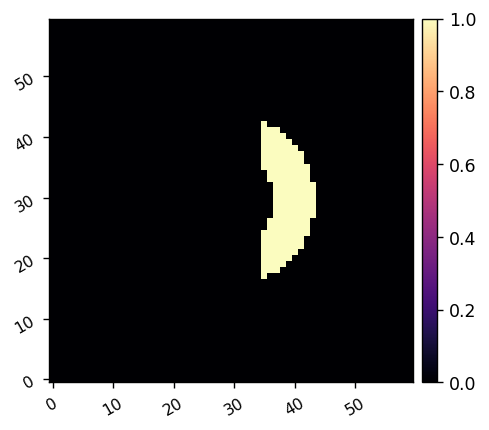

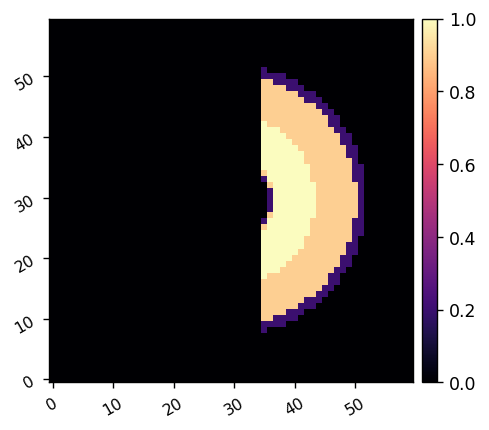

In [6]:
reload(utils)
xfp = (xp.linspace(-c.npsf/2, c.npsf/2-1, c.npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow1(weight_map)

# Create probe and fourier modes

In [1]:
reload(utils)
probe_amp = 2.5e-8
fourier_modes, fs = utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.5) 
probe_modes = utils.create_fourier_probes(fourier_modes, shift_cos=(10,10), shift_sin=(-10,-10), plot=True)

probe_1_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[0], int(2*c.Nact)))))
probe_2_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[1], int(2*c.Nact)))))
imshow2(abs(probe_1_response), abs(probe_2_response))

NameError: name 'reload' is not defined

In [8]:
Nacts = int(c.dm_mask.sum())

calib_amp = 2.5e-9

calib_modes = xp.zeros((Nacts, c.Nact, c.Nact))
count=0
for i in range(c.Nact):
    for j in range(c.Nact):
        if c.dm_mask[i,j]:
            calib_modes[count, i,j] = 1
            count+=1
            
calib_modes = calib_modes[:,:].reshape(Nacts, c.Nact**2)

# import time
# for i in range(Nacts):
#     try:
#         wfsc.imshow1(calib_modes[i].reshape(Nact,Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

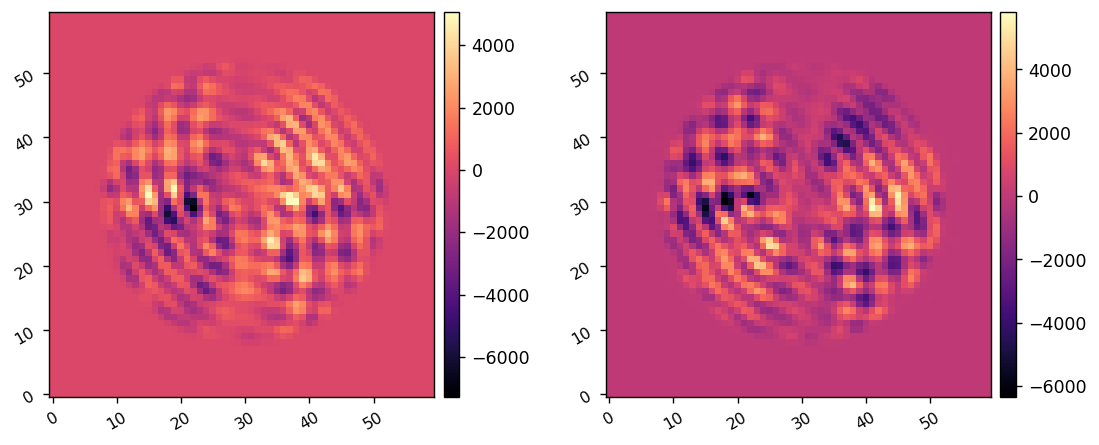

In [13]:
reload(iefc_2dm)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = iefc_2dm.take_measurement(c, probe_modes, probe_amp, return_all=True)
diff_ims = differential_images.reshape(2, c.npsf, c.npsf)
imshow2(diff_ims[0], diff_ims[1], wspace=0.35)

In [ ]:
reload(iefc_2dm)
response_matrix, response_cube = iefc_2dm.calibrate(c, 
                                                control_mask.ravel(),
                                                probe_amp, probe_modes, 
                                                calib_amp, utils.ensure_np_array(calib_modes), 
                                                return_all=True)


In [149]:
# date = 20230629
# date = 20230703
date = today

response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_cube_{date}.fits'))

In [150]:
crop_mask = xp.zeros((64,64), dtype=bool)
crop_mask[2:62, 2:62] = True

response_cube_new = response_cube[:,:,crop_mask.ravel()]
print(response_cube_new.shape)
response_cube_new = xp.concatenate((response_cube_new[::2], response_cube_new[1::2]))
print(response_cube_new.shape)
response_matrix_new = response_cube_new[:,:,control_mask.ravel()].reshape(3608, -1).T
print(response_matrix_new.shape)

(3608, 2, 3600)
(3608, 2, 3600)
(1108, 3608)


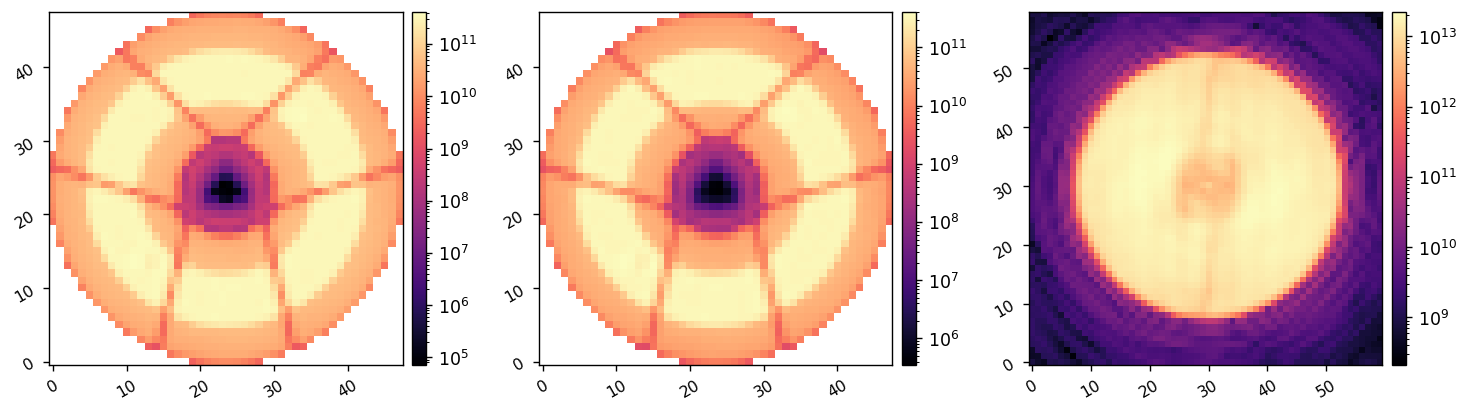

In [138]:
reload(wfsc.utils)
dm1_response = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[::2], c.dm_mask)
dm2_response = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[1::2], c.dm_mask)
fp_response = xp.sum(abs(response_cube_new), axis=(0,1)).reshape(npsf, npsf)

wfsc.imshow3(dm1_response , dm2_response, fp_response, lognorm=True)

# Run IEFC

(1108, 1108) (1108, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 10


(3608,)

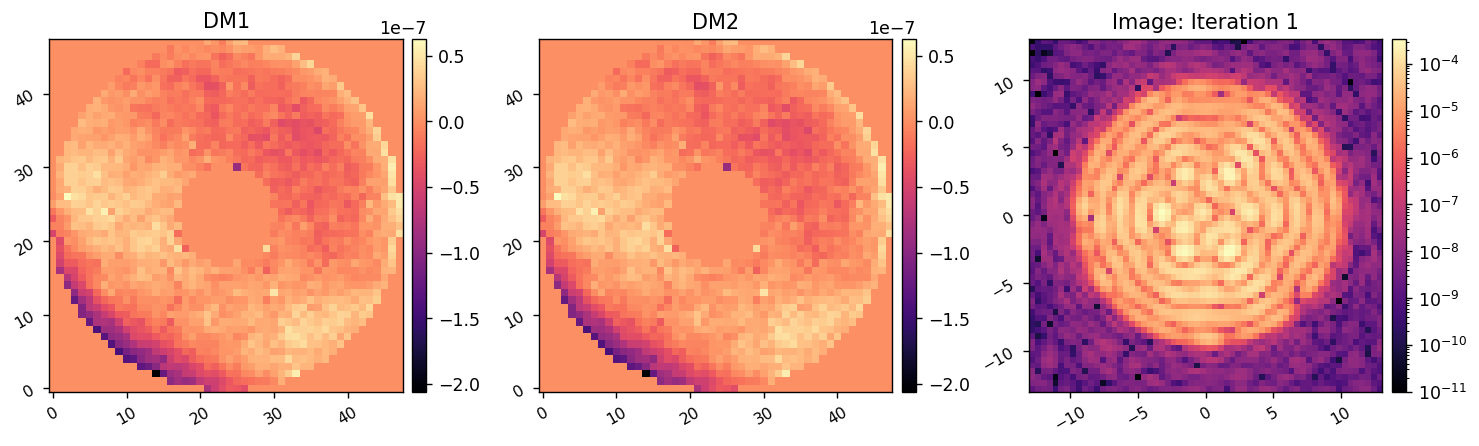

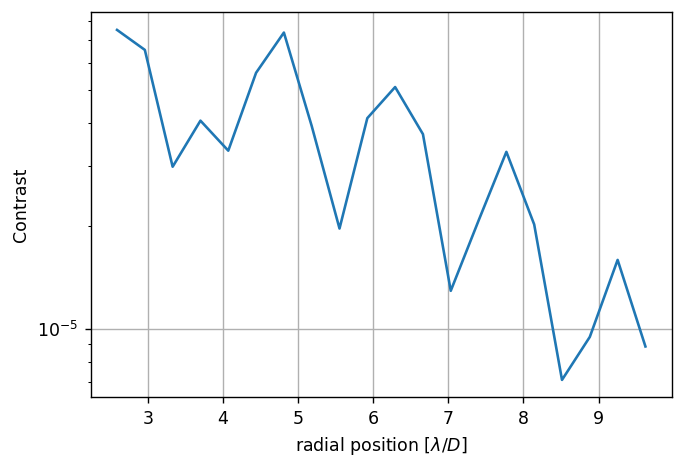

	Closed-loop iteration 2 / 10


(3608,)

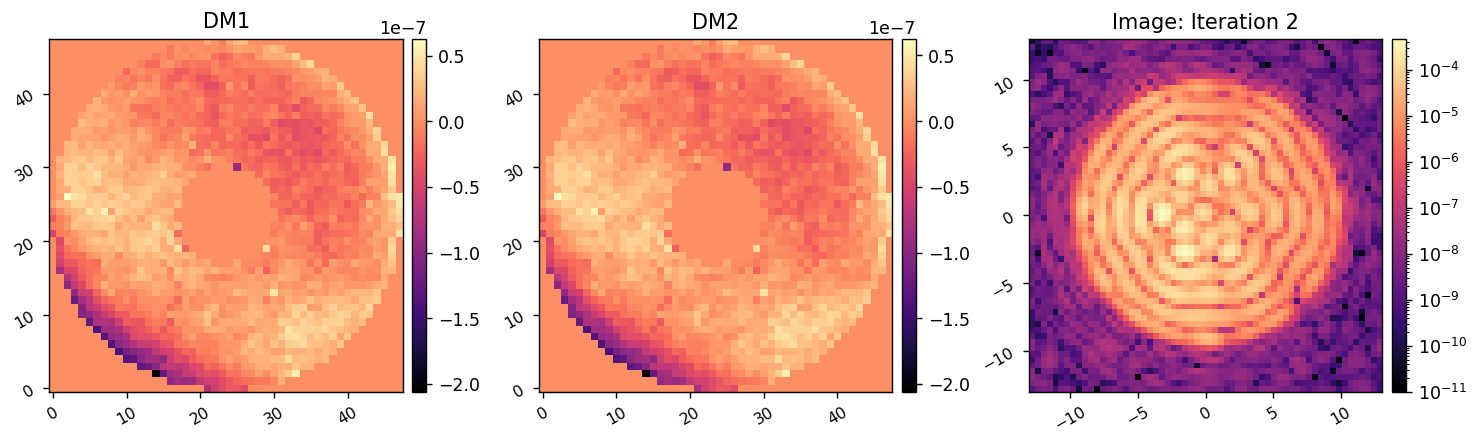

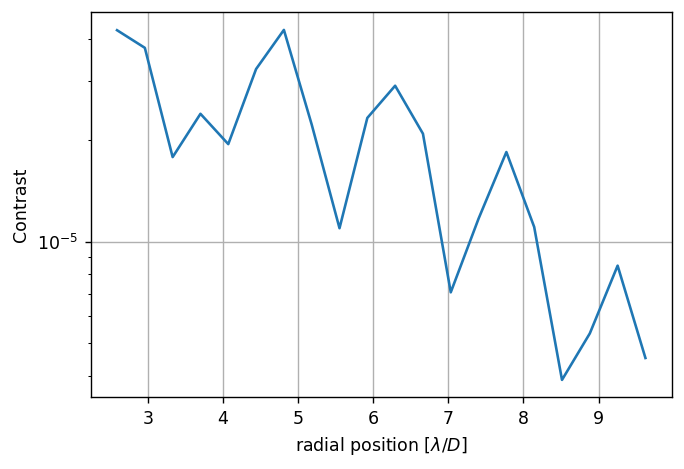

	Closed-loop iteration 3 / 10


(3608,)

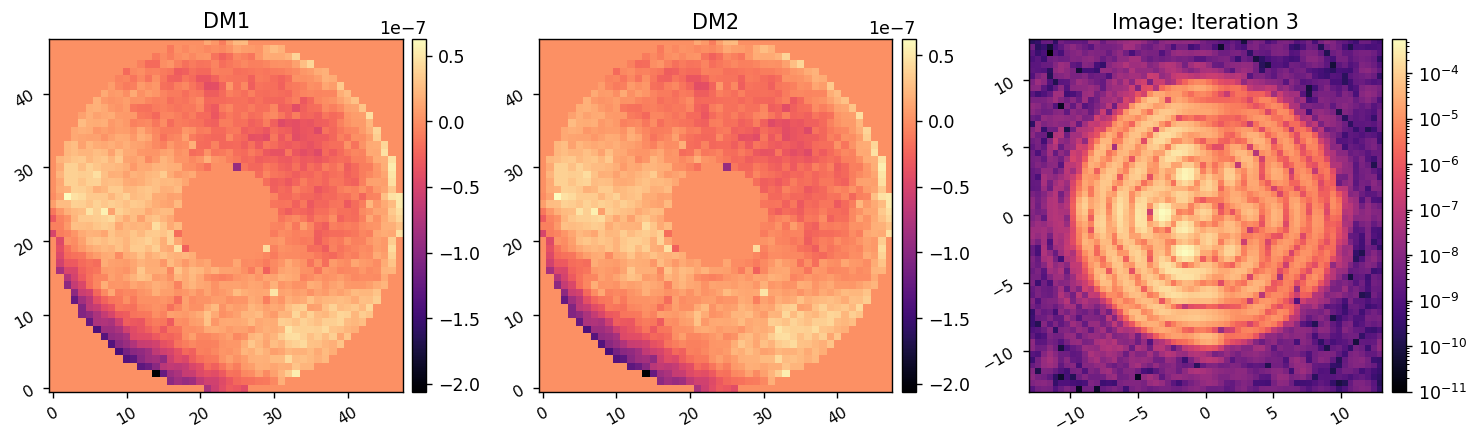

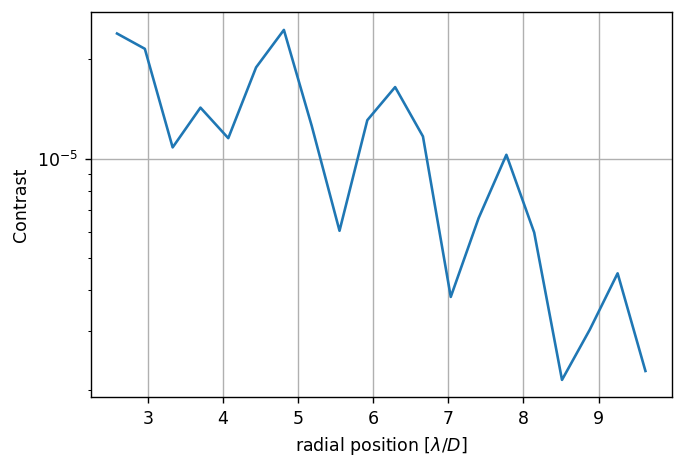

	Closed-loop iteration 4 / 10


(3608,)

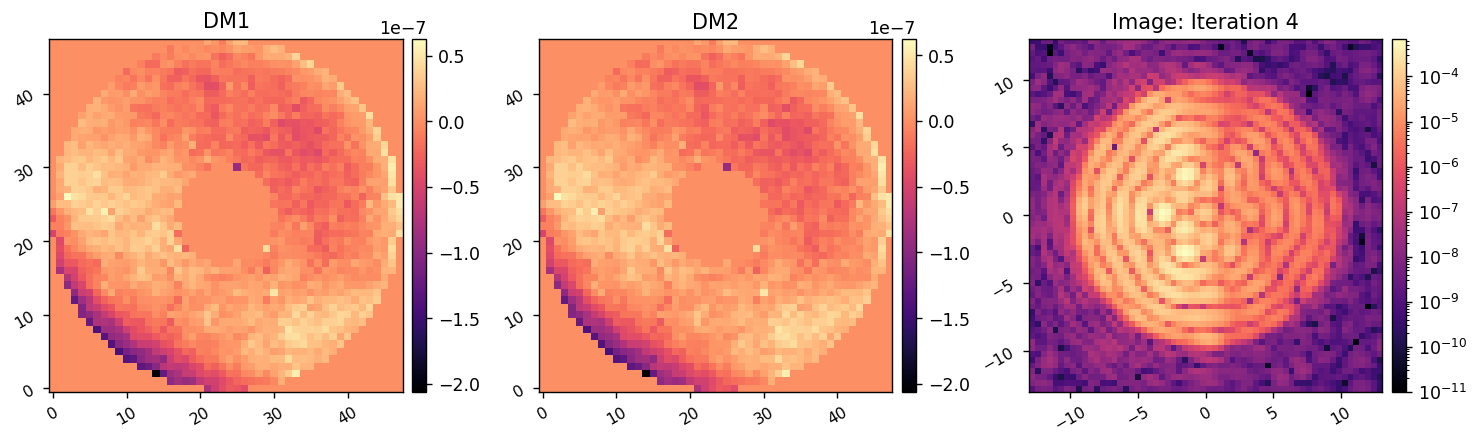

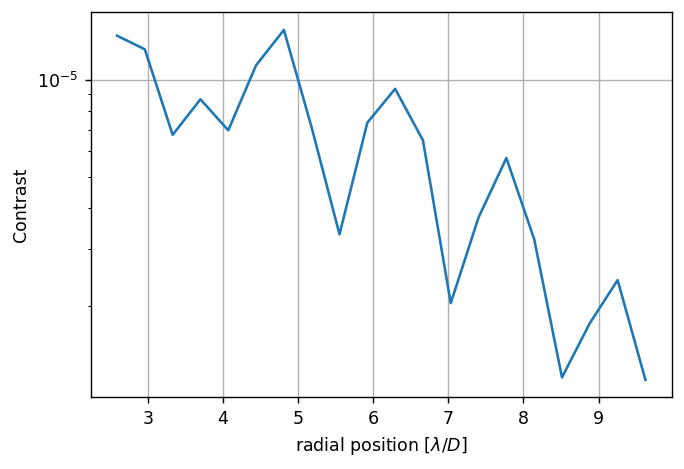

	Closed-loop iteration 5 / 10


(3608,)

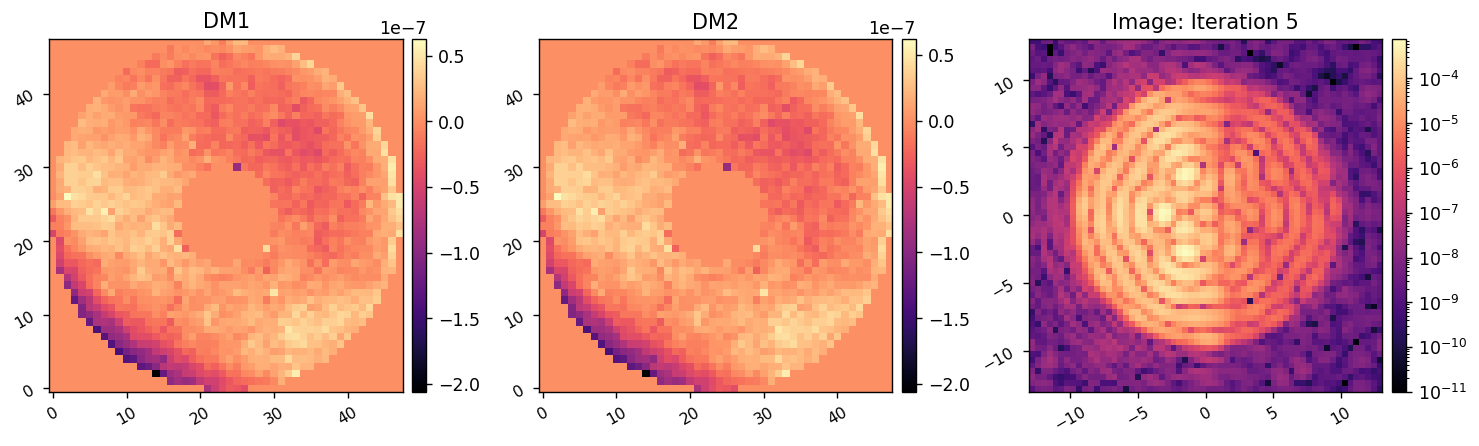

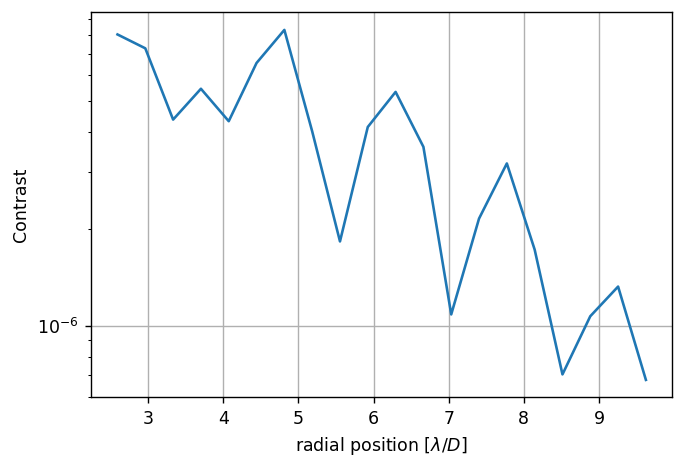

	Closed-loop iteration 6 / 10


(3608,)

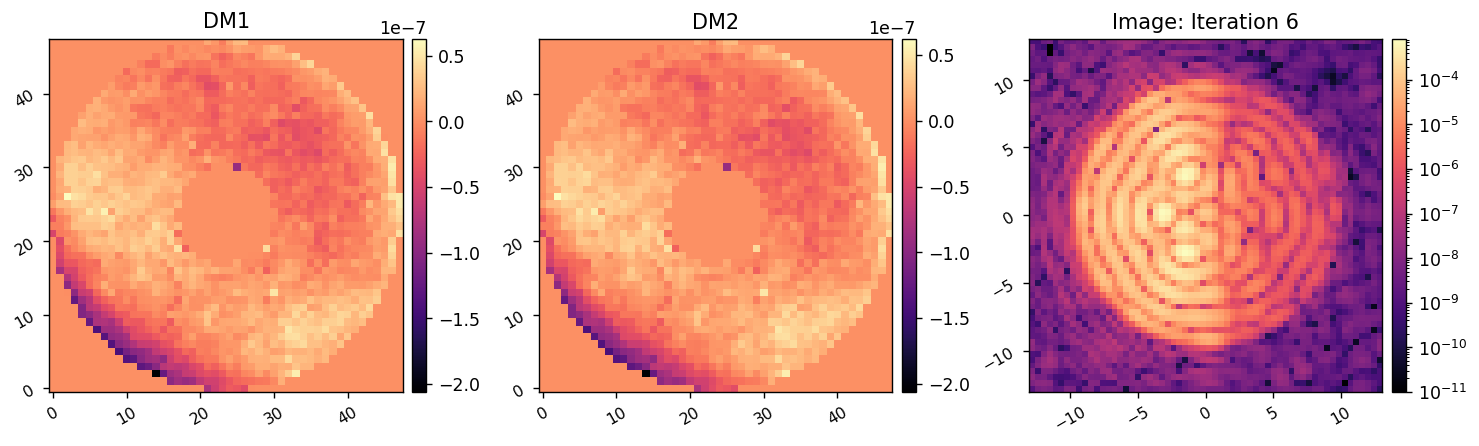

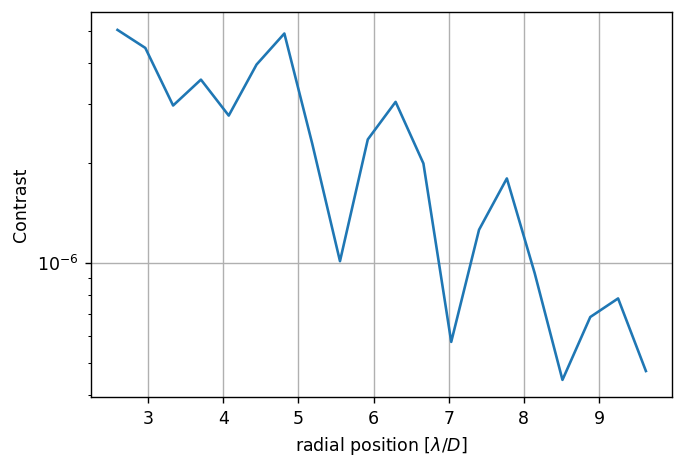

	Closed-loop iteration 7 / 10


(3608,)

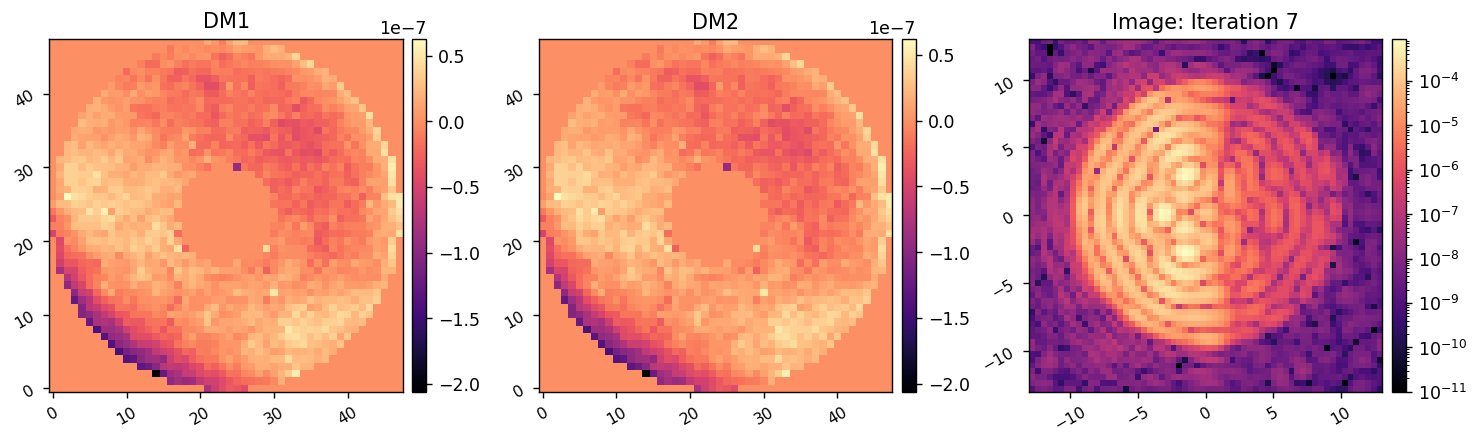

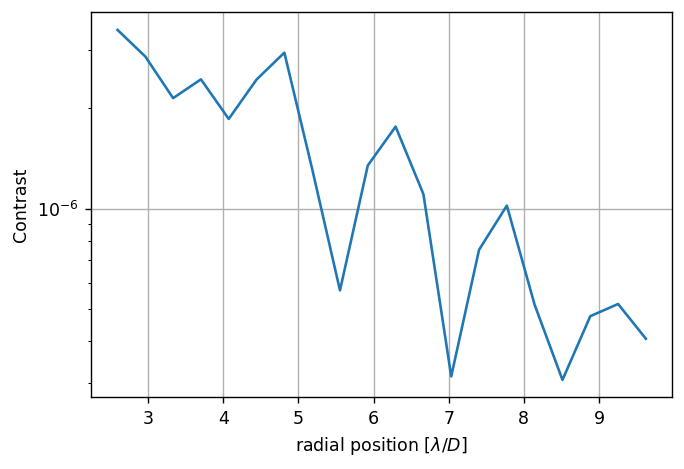

	Closed-loop iteration 8 / 10


(3608,)

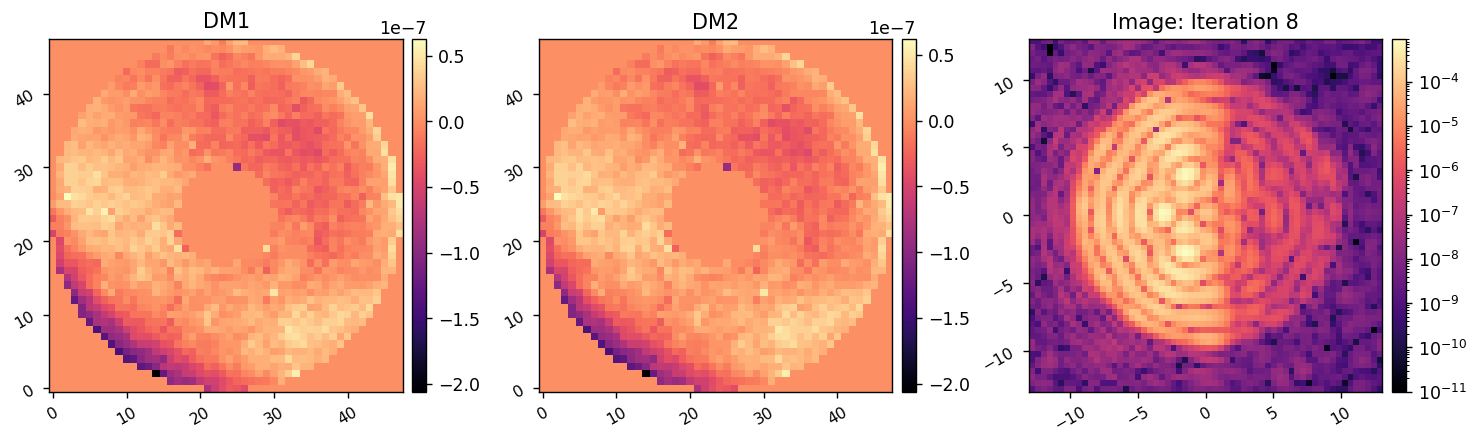

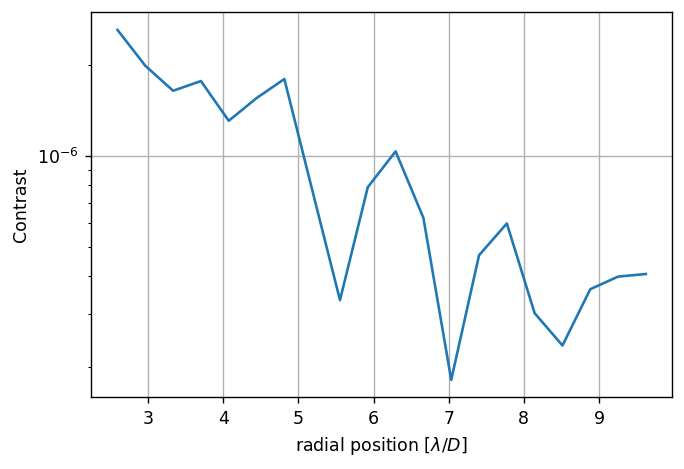

	Closed-loop iteration 9 / 10


(3608,)

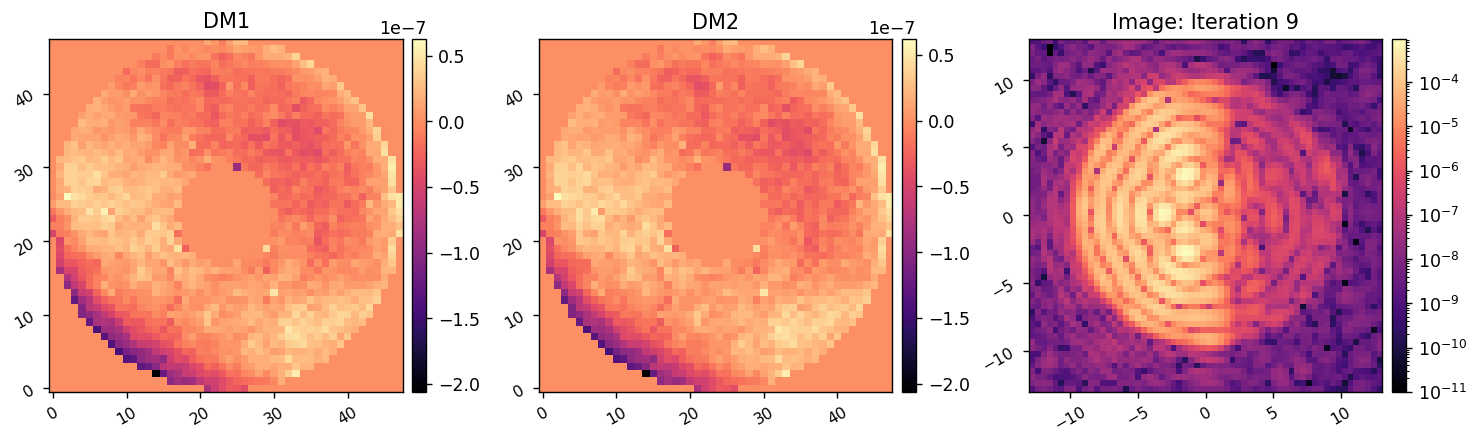

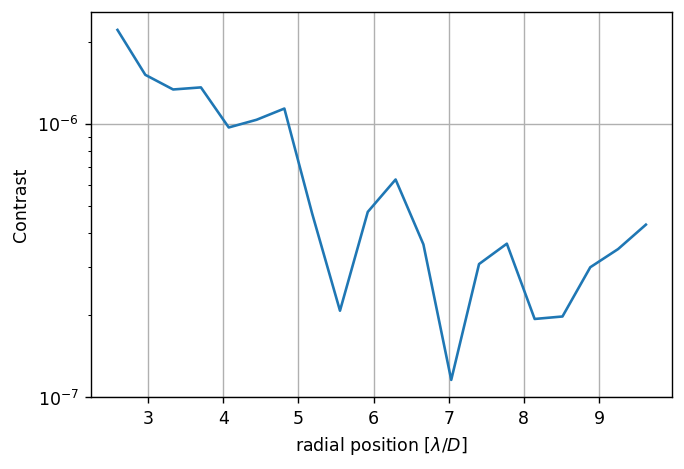

	Closed-loop iteration 10 / 10


(3608,)

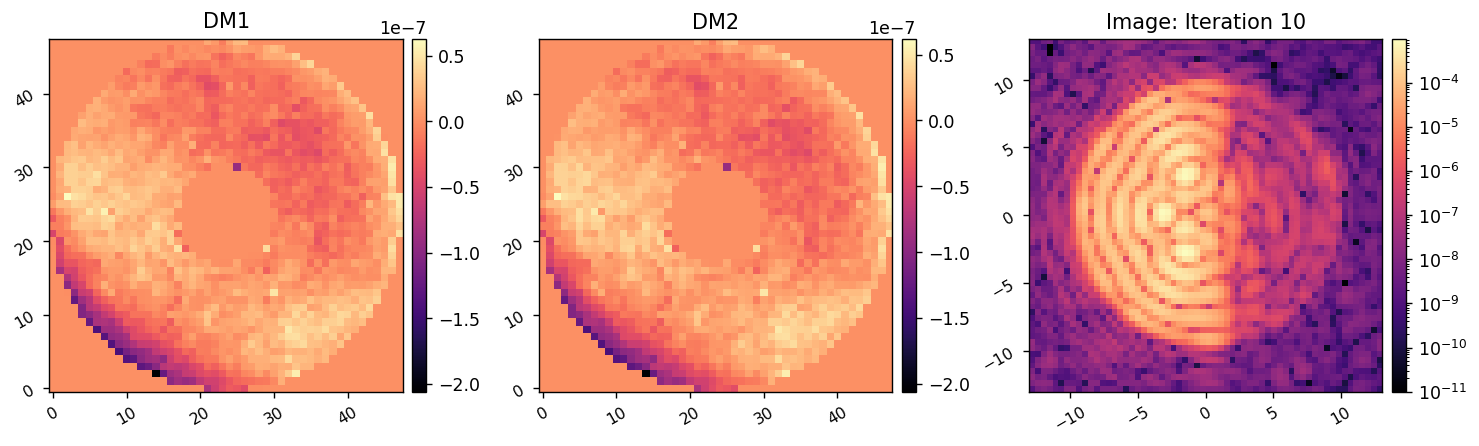

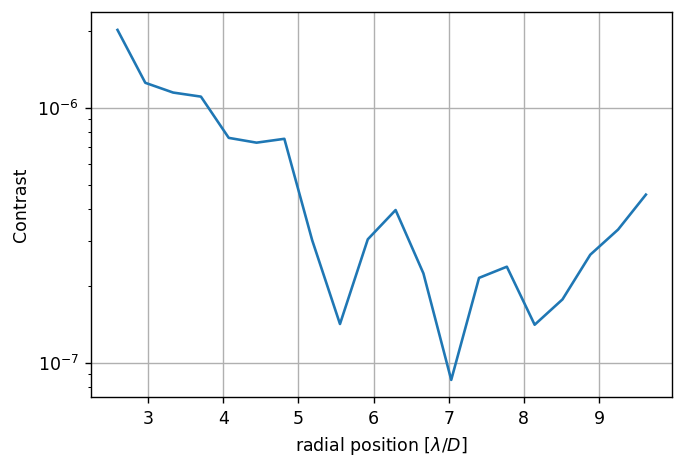

I-EFC loop completed in 24.619s.


In [151]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-2
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_new, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 10


(3608,)

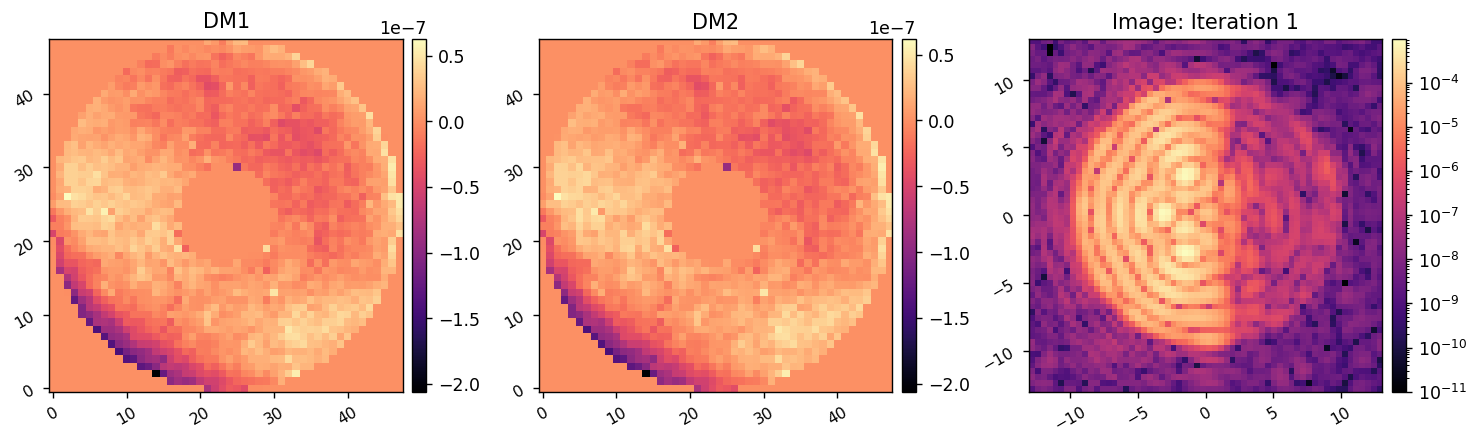

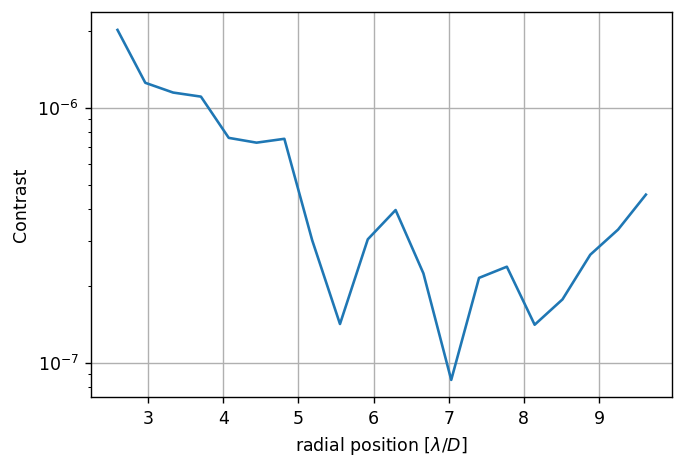

	Closed-loop iteration 2 / 10


(3608,)

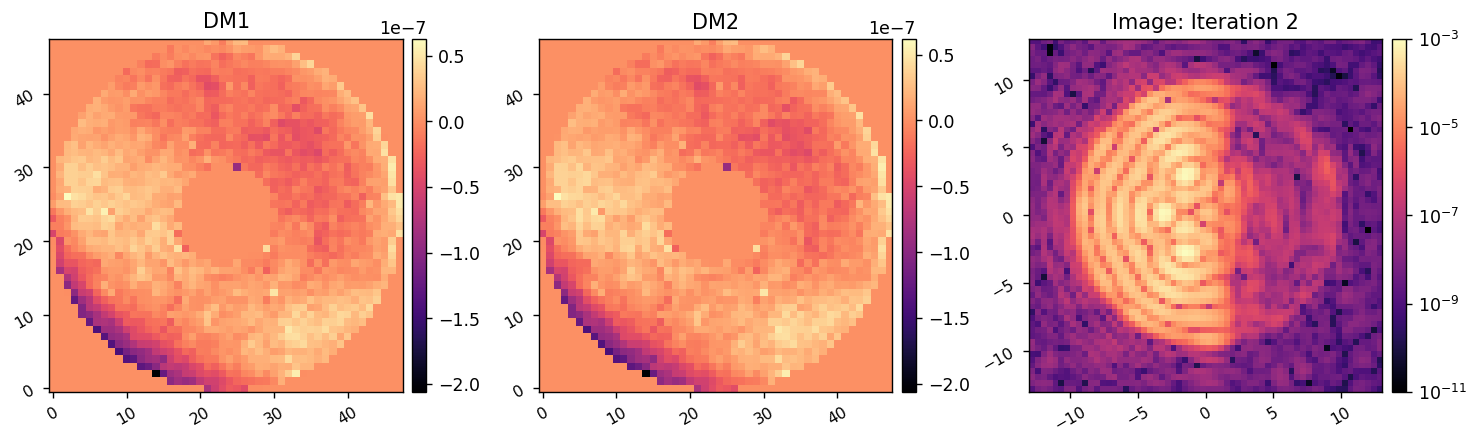

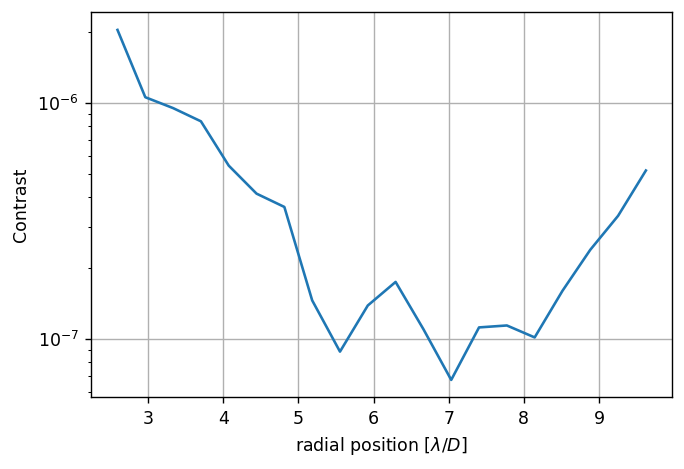

	Closed-loop iteration 3 / 10


(3608,)

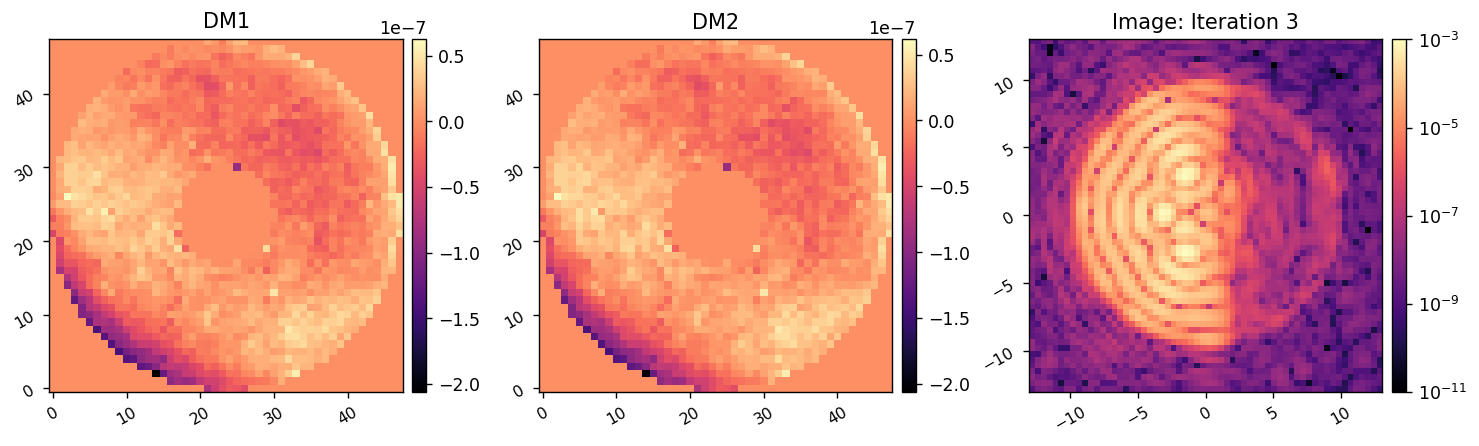

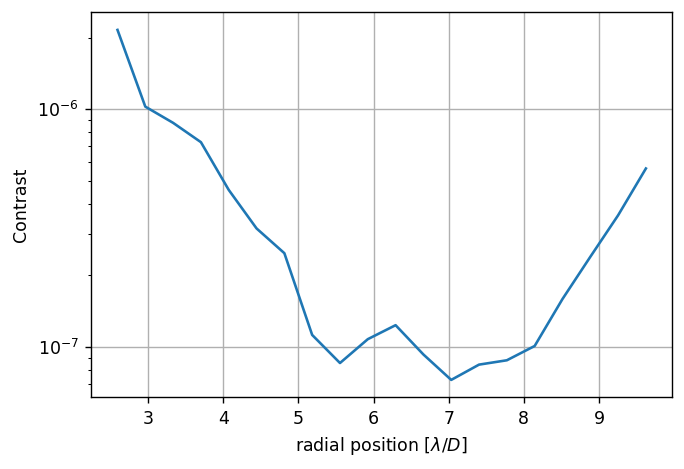

	Closed-loop iteration 4 / 10


(3608,)

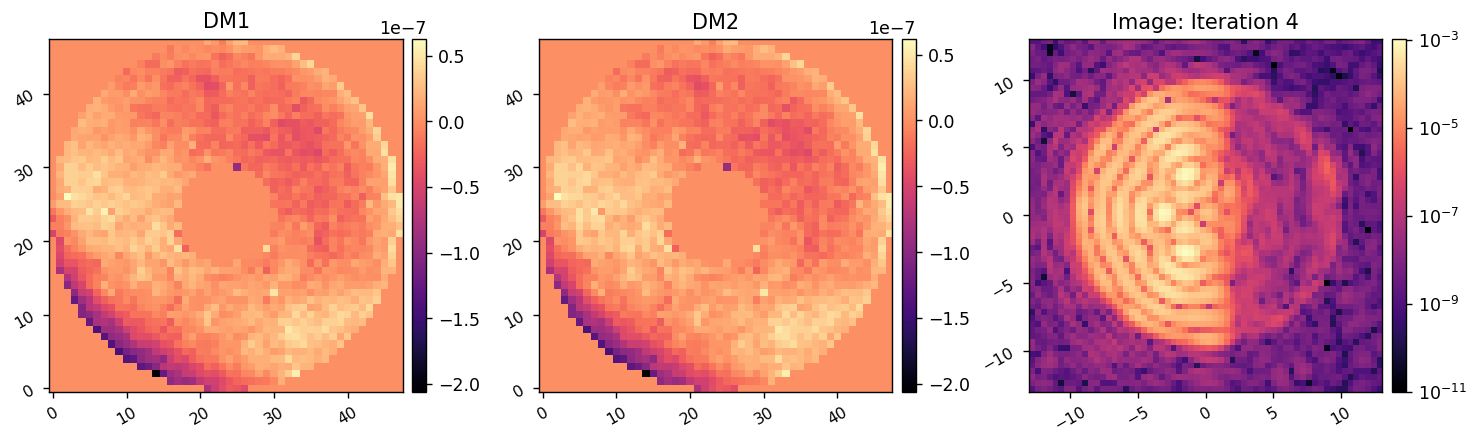

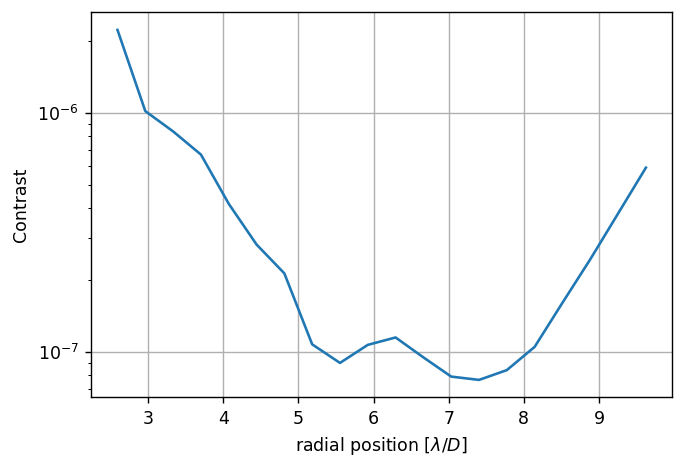

	Closed-loop iteration 5 / 10


(3608,)

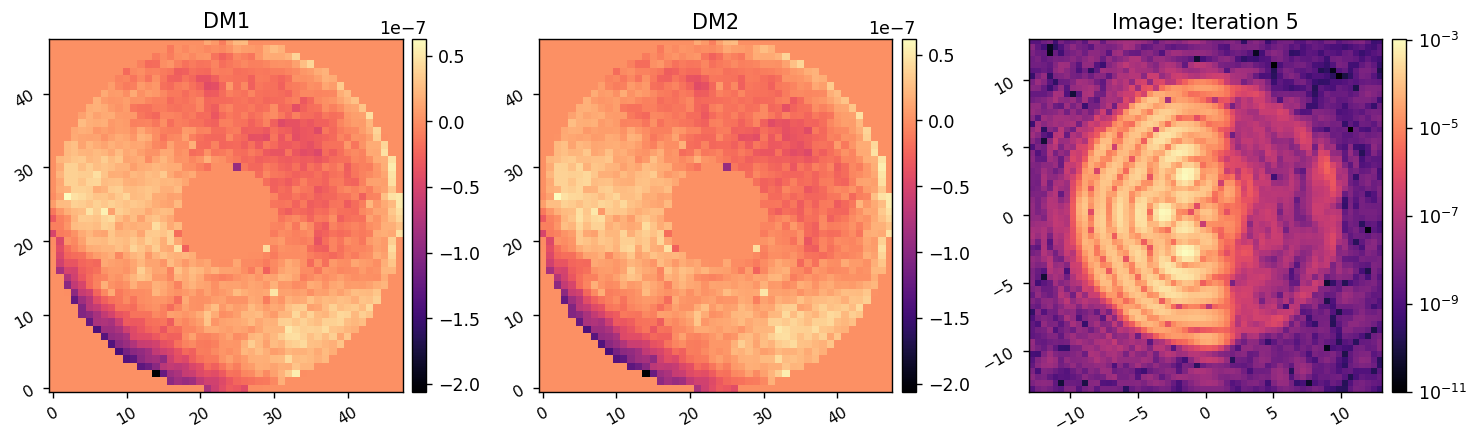

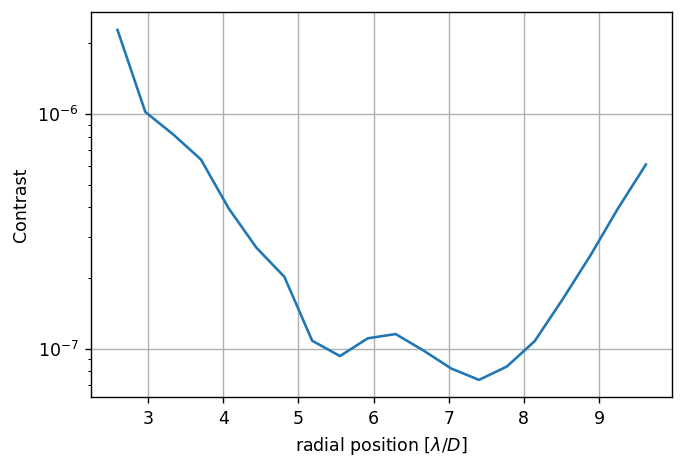

	Closed-loop iteration 6 / 10


(3608,)

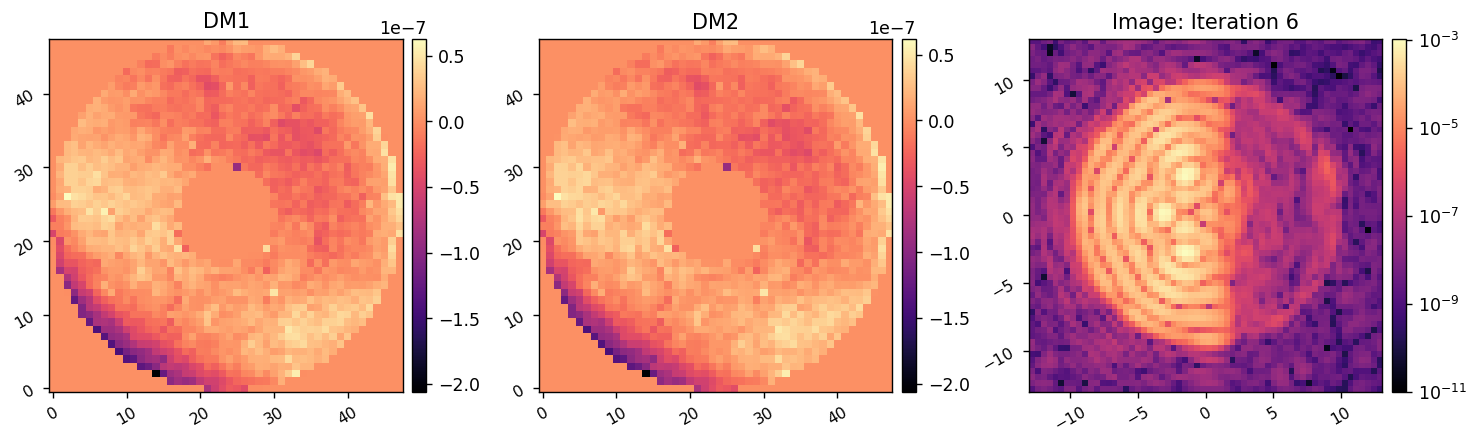

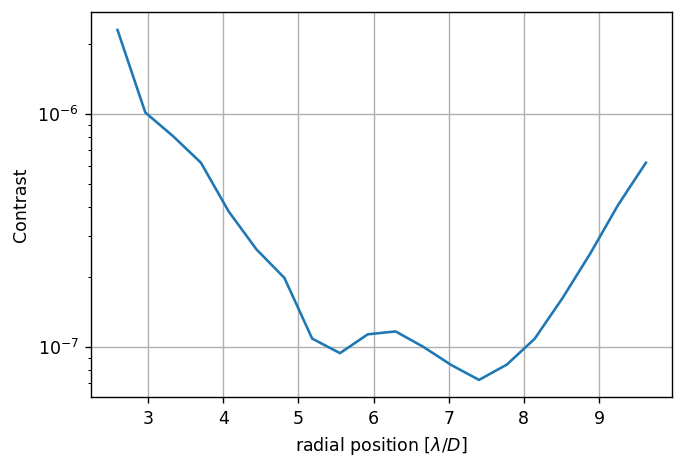

	Closed-loop iteration 7 / 10


(3608,)

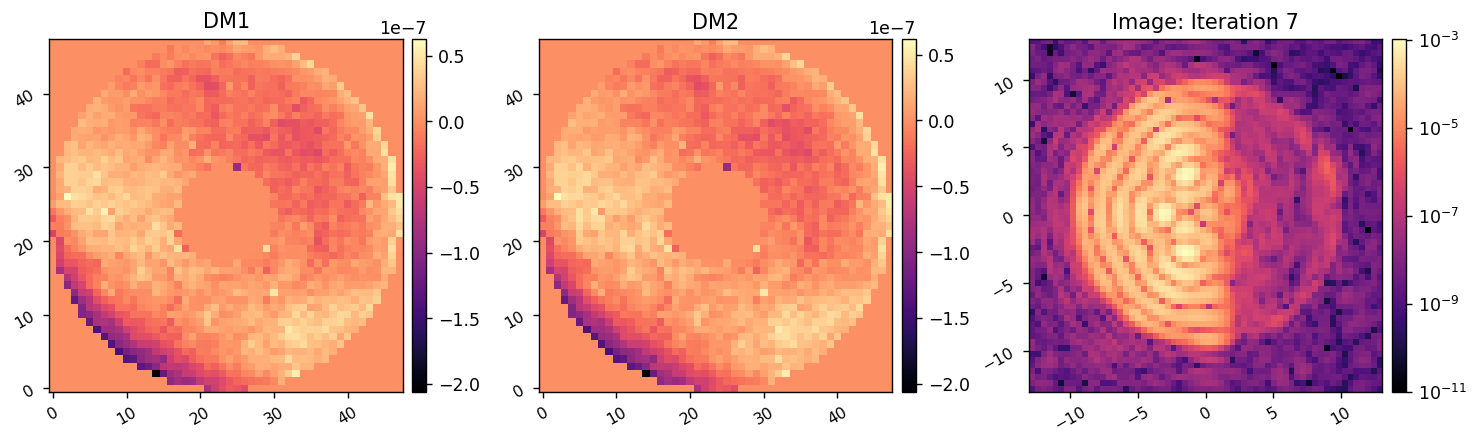

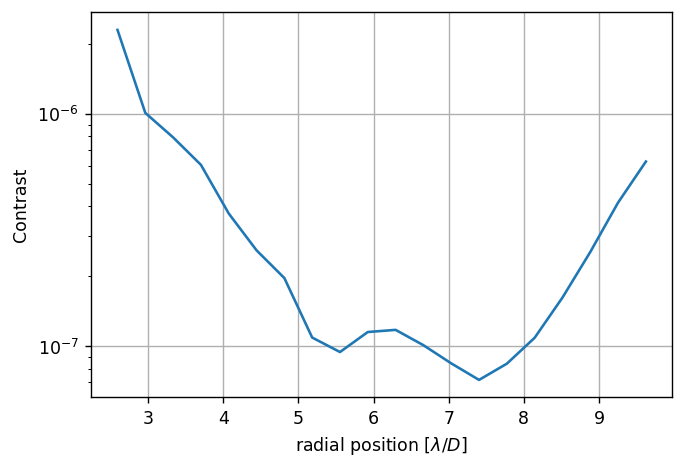

	Closed-loop iteration 8 / 10


(3608,)

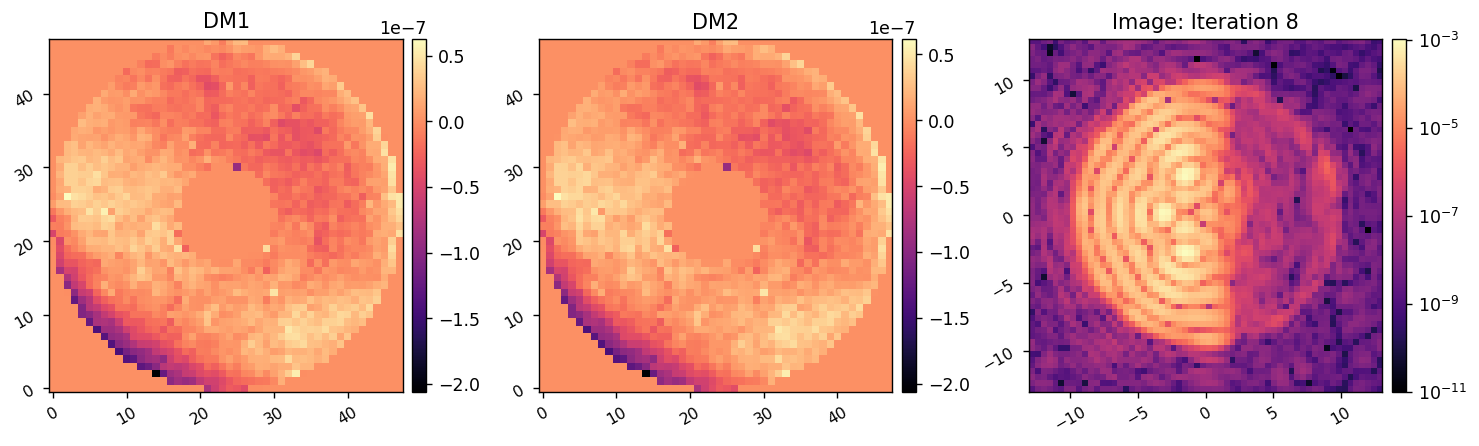

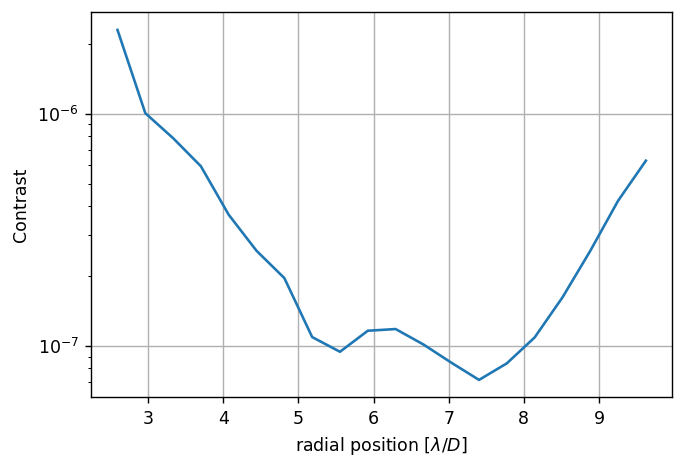

	Closed-loop iteration 9 / 10


(3608,)

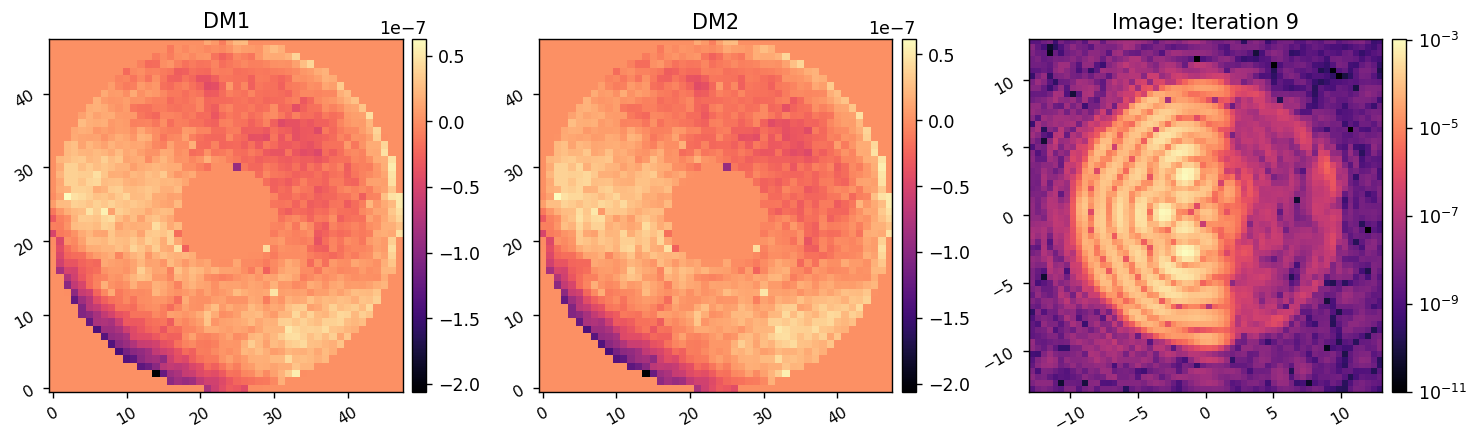

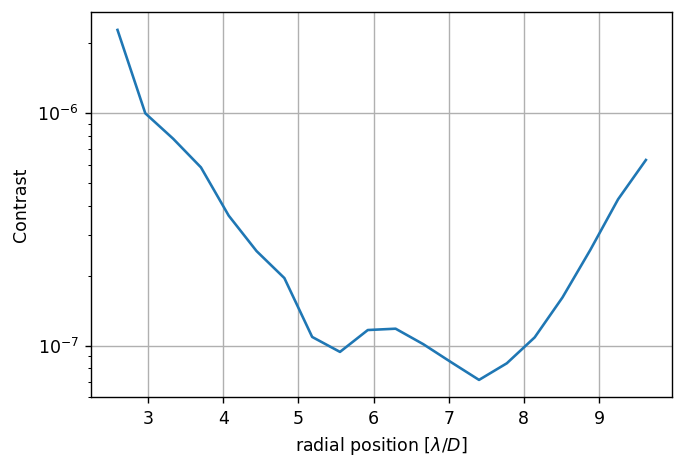

	Closed-loop iteration 10 / 10


(3608,)

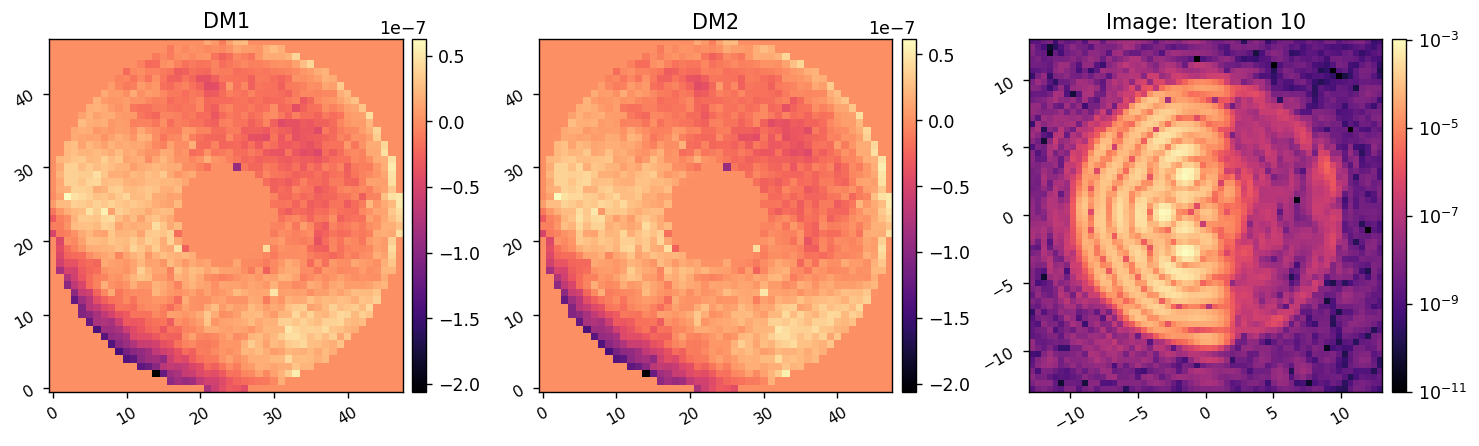

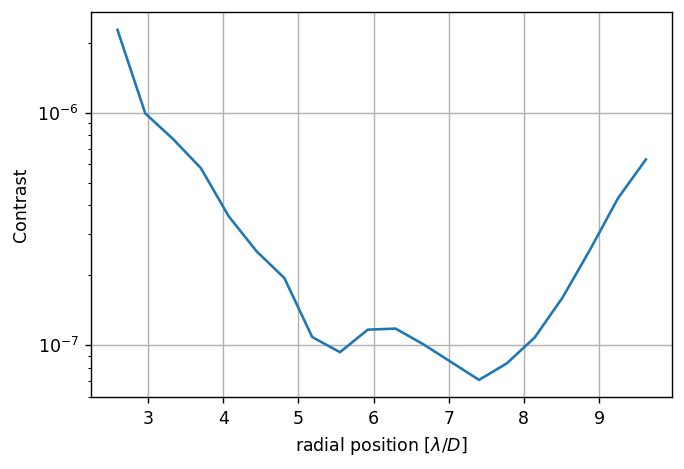

I-EFC loop completed in 23.206s.


In [152]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_new, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3608,)

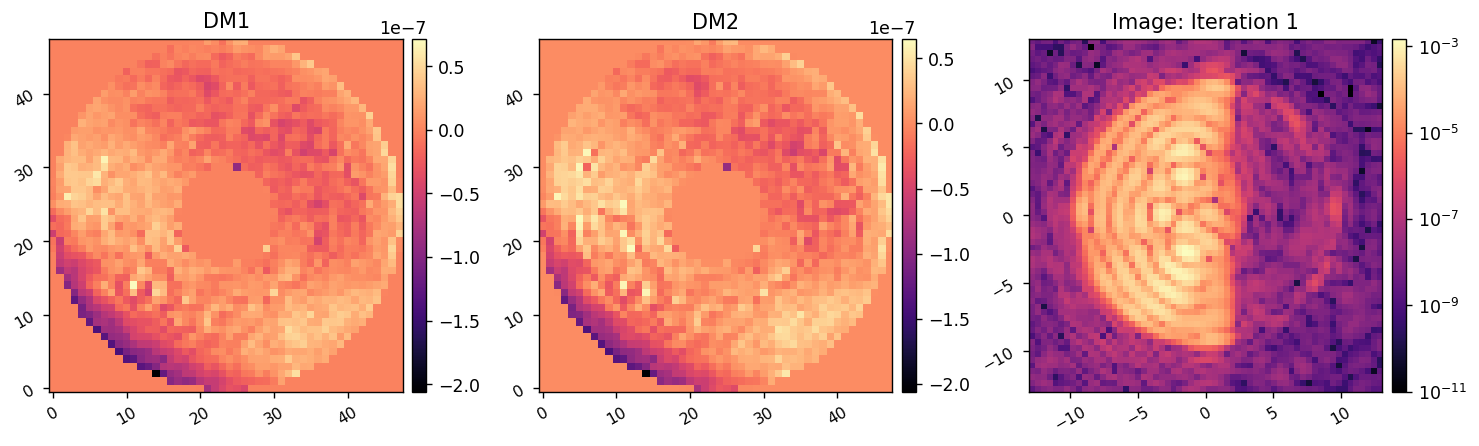

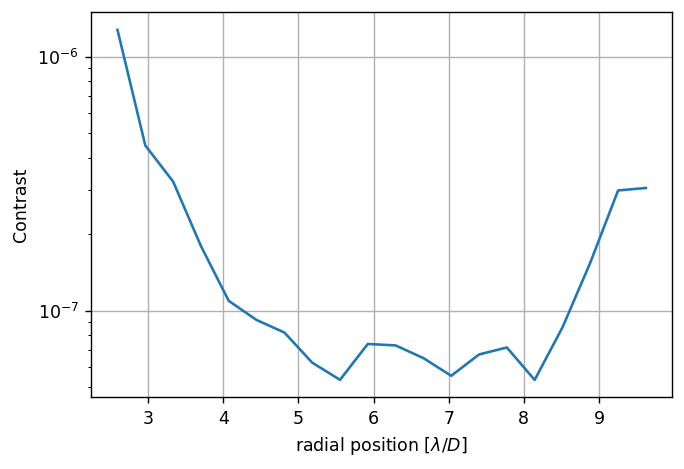

	Closed-loop iteration 2 / 5


(3608,)

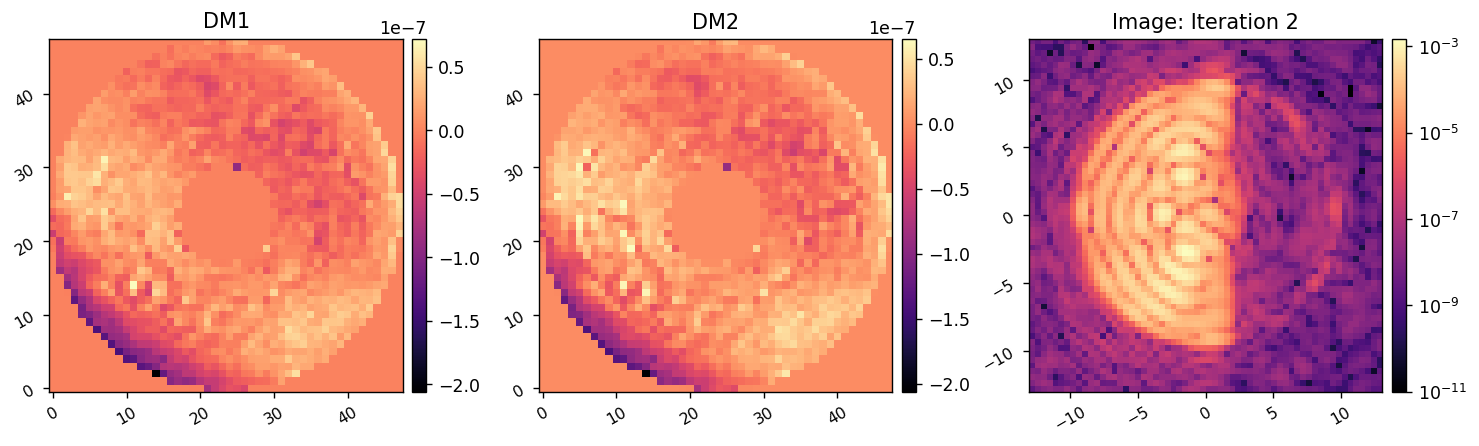

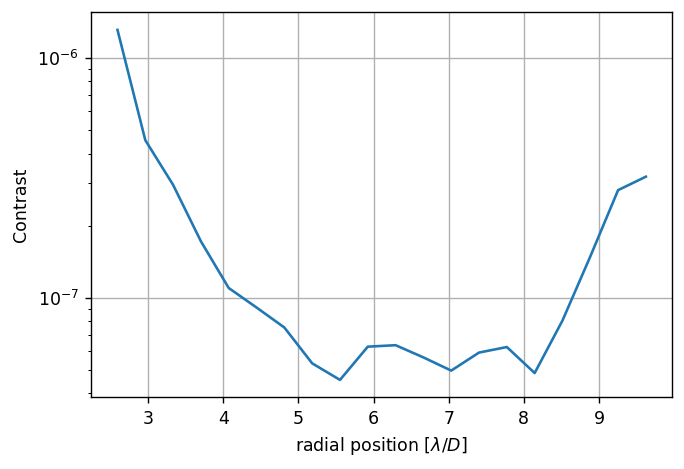

	Closed-loop iteration 3 / 5


(3608,)

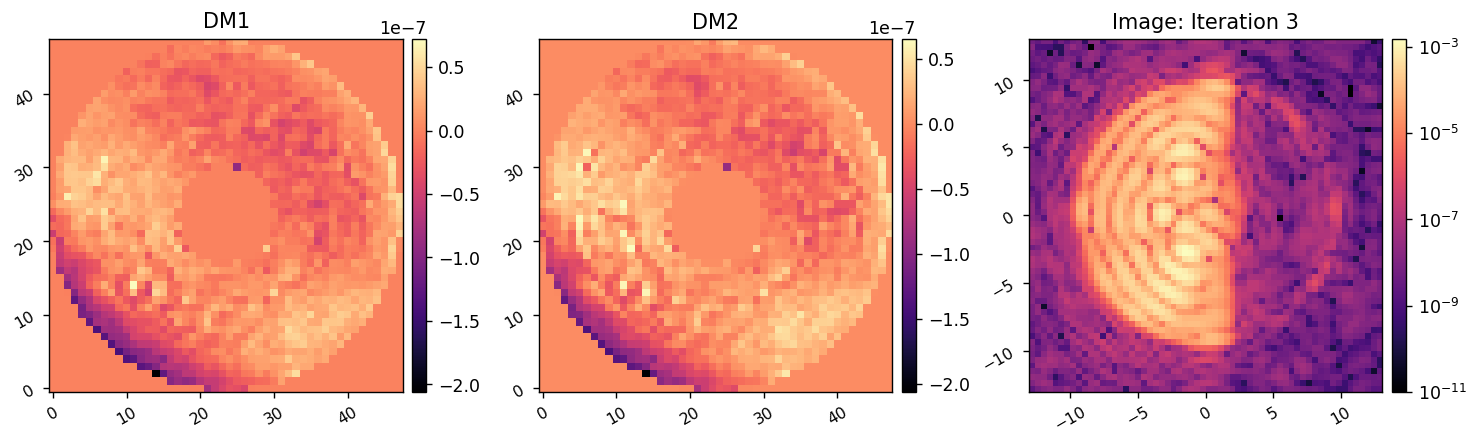

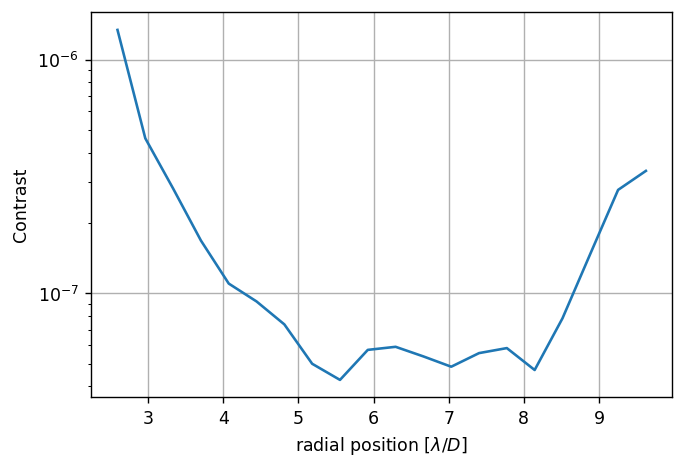

	Closed-loop iteration 4 / 5


(3608,)

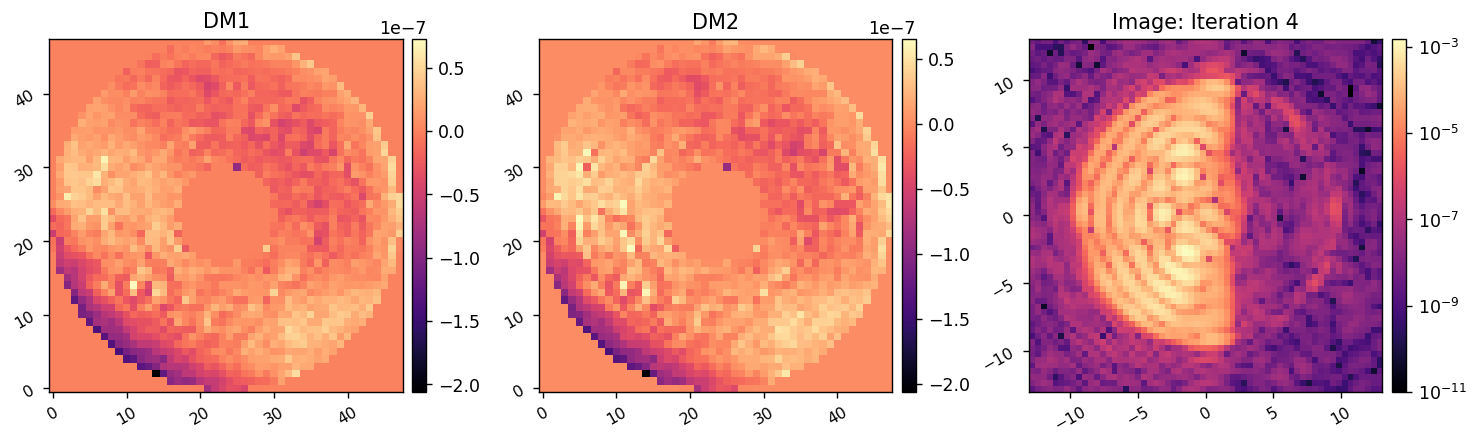

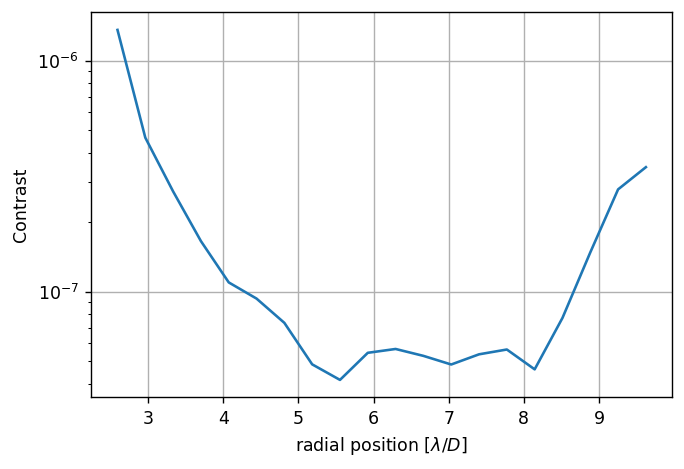

	Closed-loop iteration 5 / 5


(3608,)

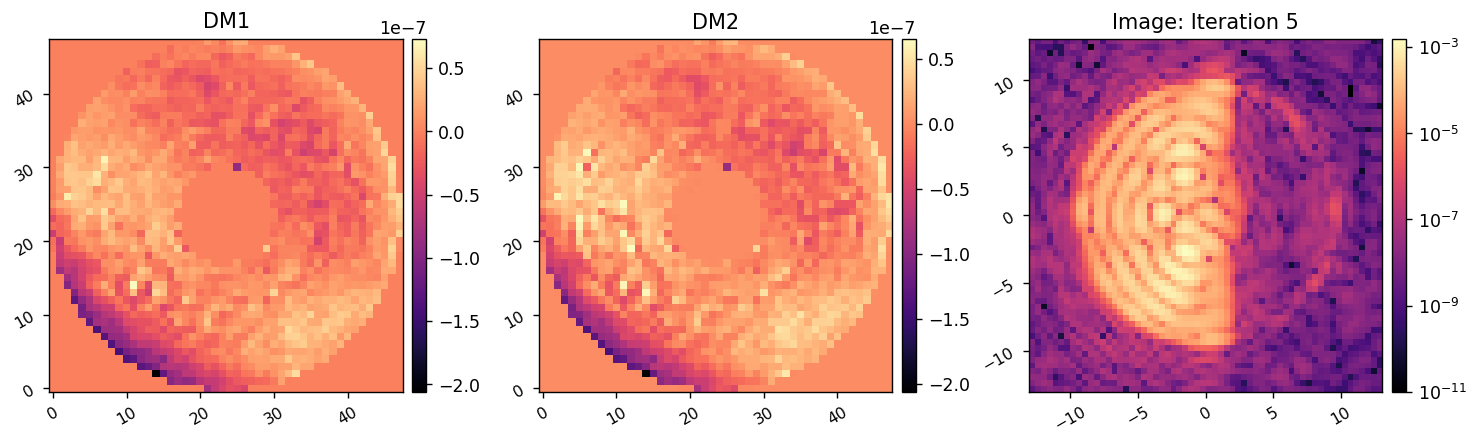

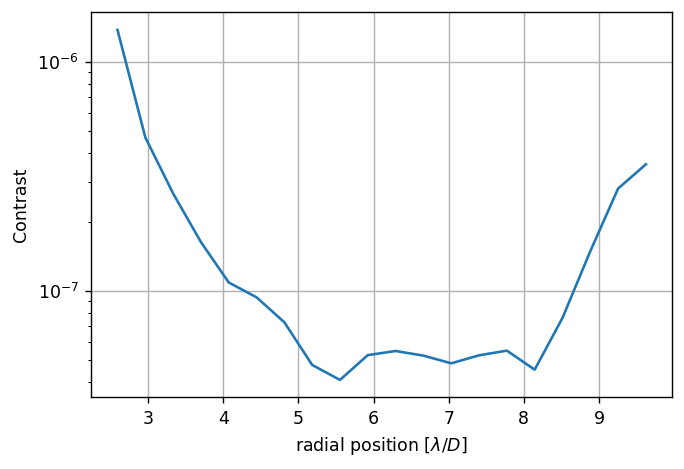

I-EFC loop completed in 11.710s.


In [161]:
reg_cond = 3*5e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_new, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

In [122]:
dm1_final_command = ensure_np_array(dm1_commands[-1])
dm2_final_command = ensure_np_array(dm2_commands[-1])


In [115]:
reload(wfsc.iefc_2dm)


response_matrix_2, response_cube_2 = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...
	Calibrated mode 1804/1804 in 9011.884s
Calibration complete.


In [120]:
type(dm1_final_command)


cupy.ndarray

(1436, 1436) (1436, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3608,)

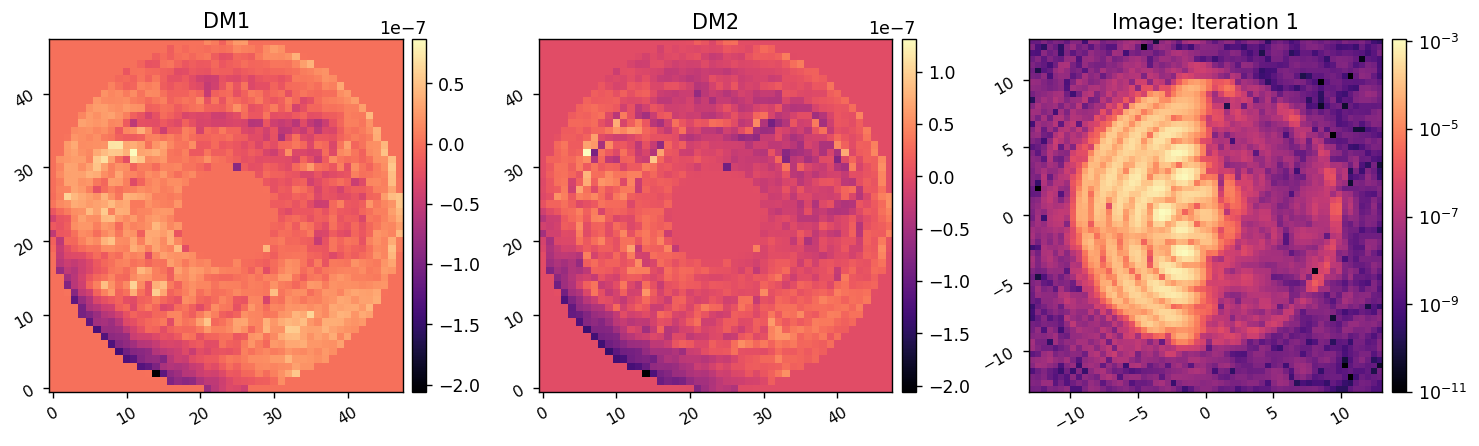

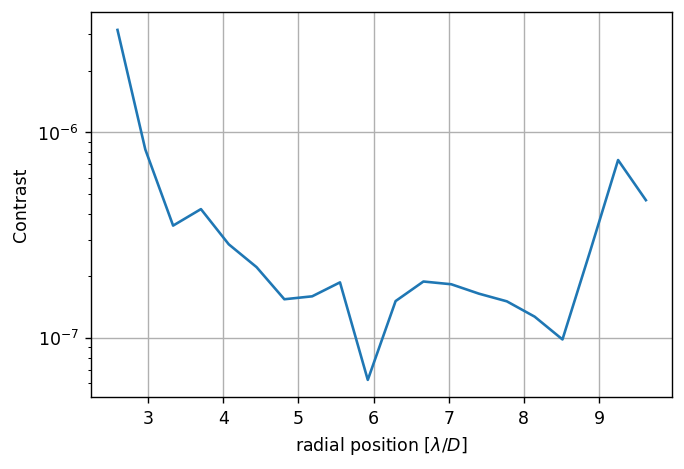

	Closed-loop iteration 2 / 5


(3608,)

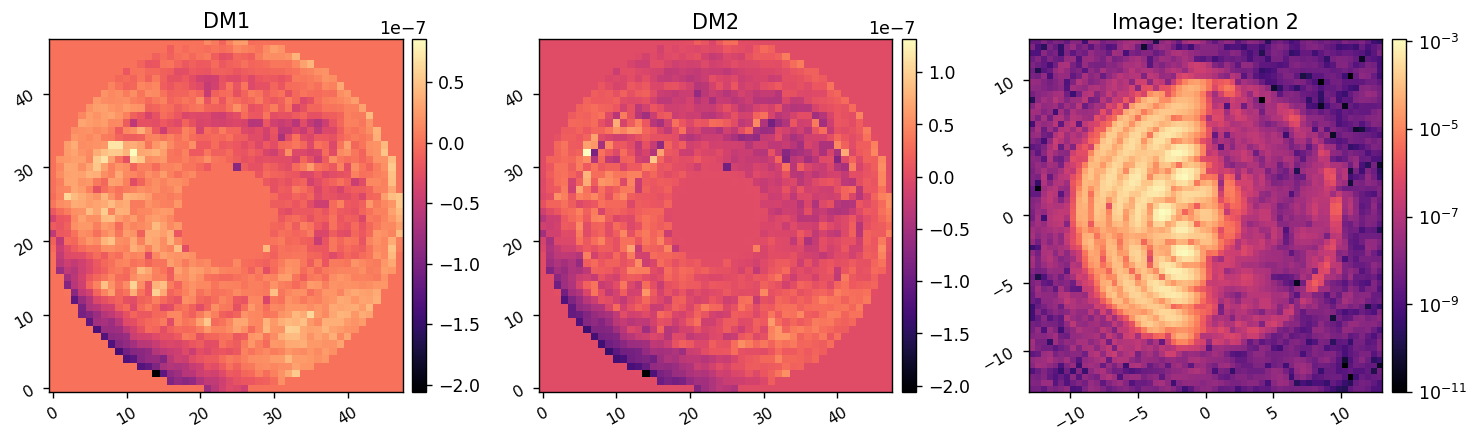

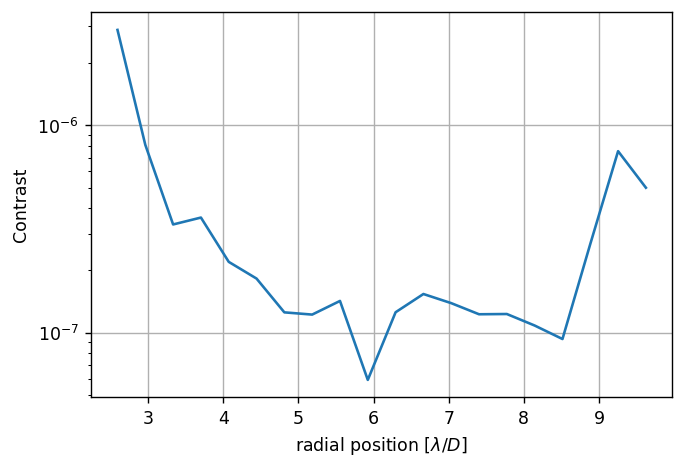

	Closed-loop iteration 3 / 5


(3608,)

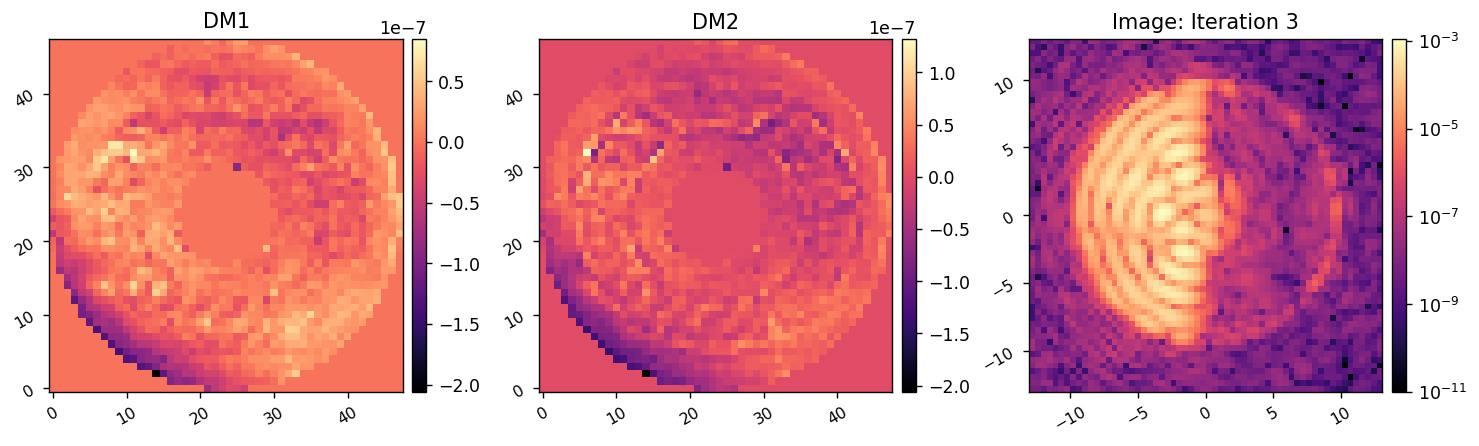

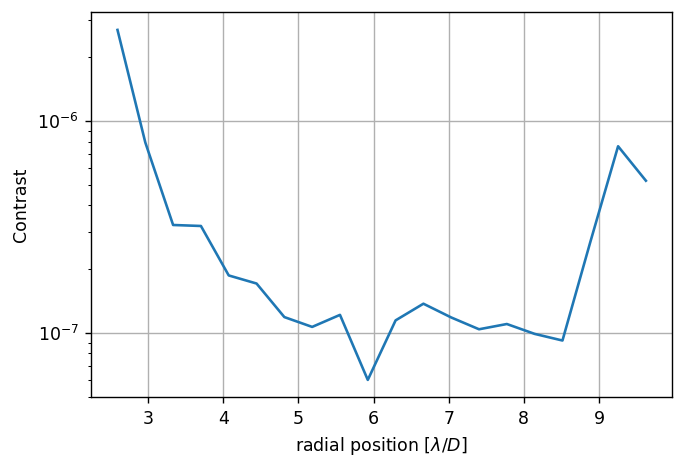

	Closed-loop iteration 4 / 5


(3608,)

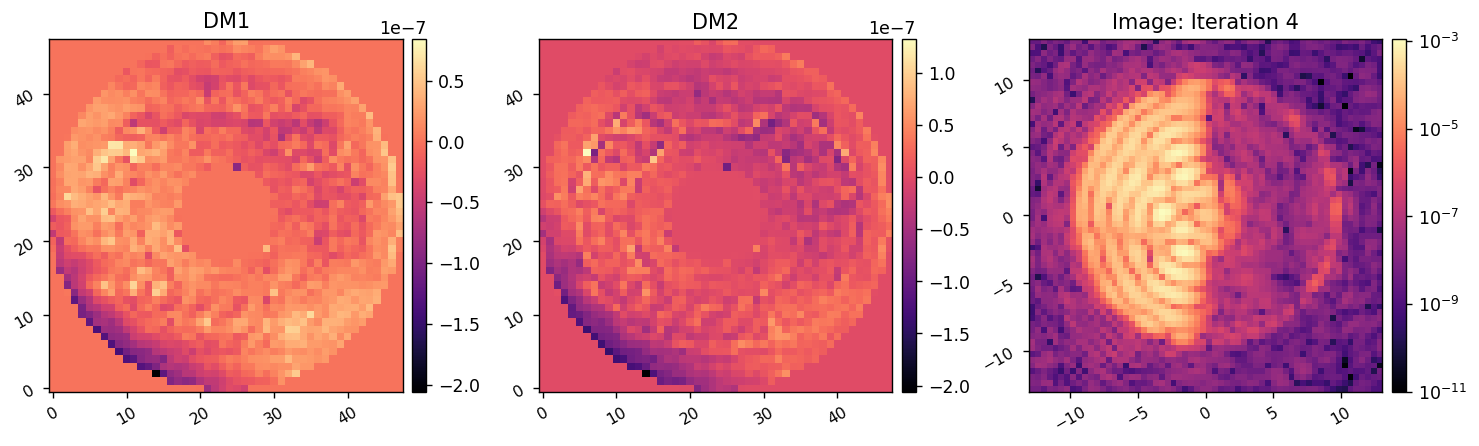

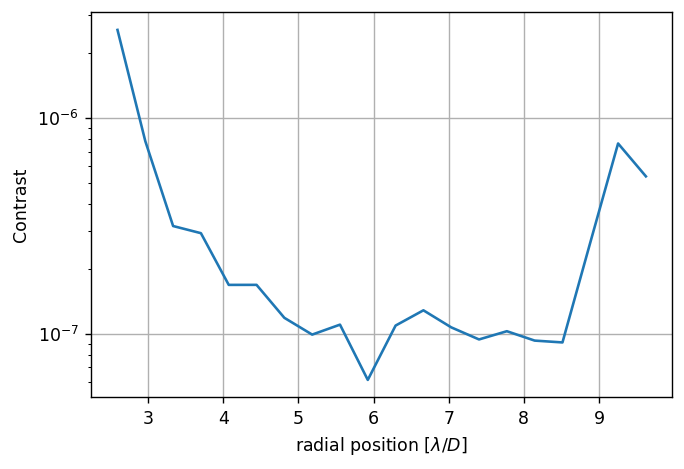

	Closed-loop iteration 5 / 5


(3608,)

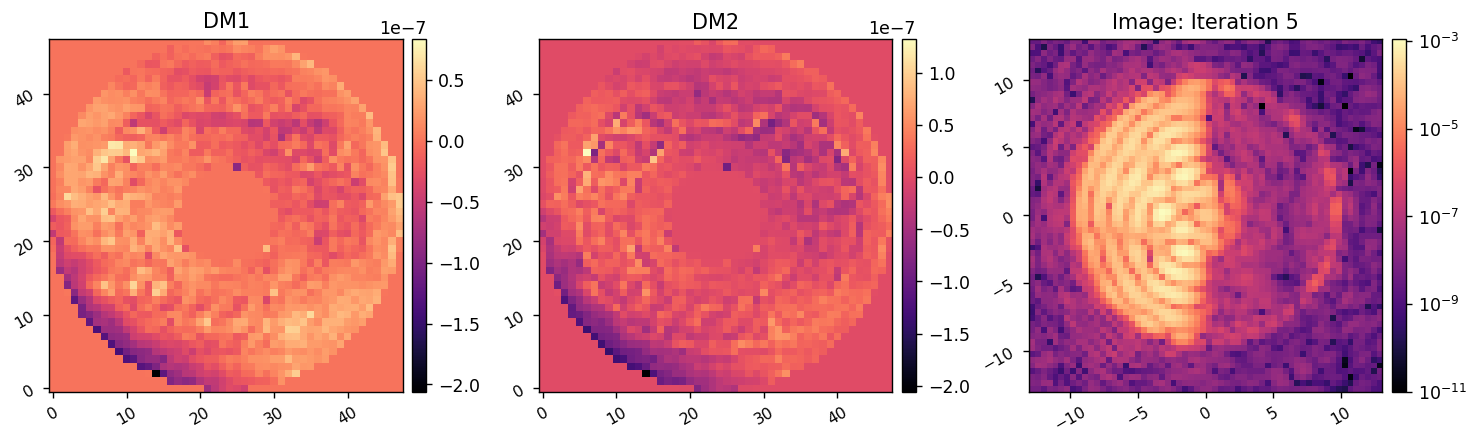

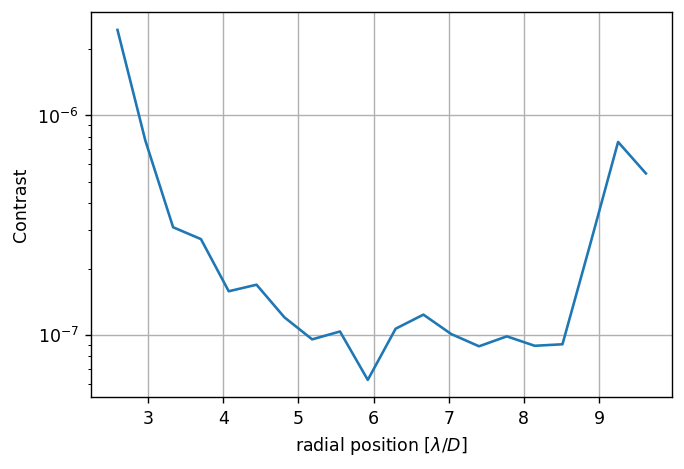

I-EFC loop completed in 11.549s.


In [123]:
c.set_dm1(dm1_final_command)
c.set_dm2(dm2_final_command)

reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_2, weight_map, nprobes=len(probe_modes), rcond=reg_cond)

images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1436, 1436) (1436, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3608,)

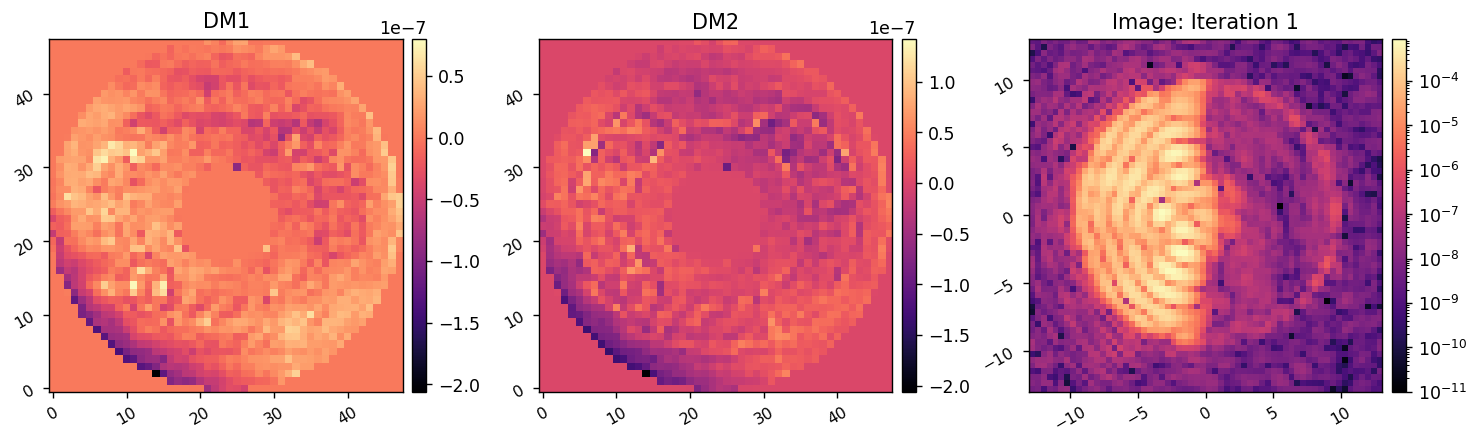

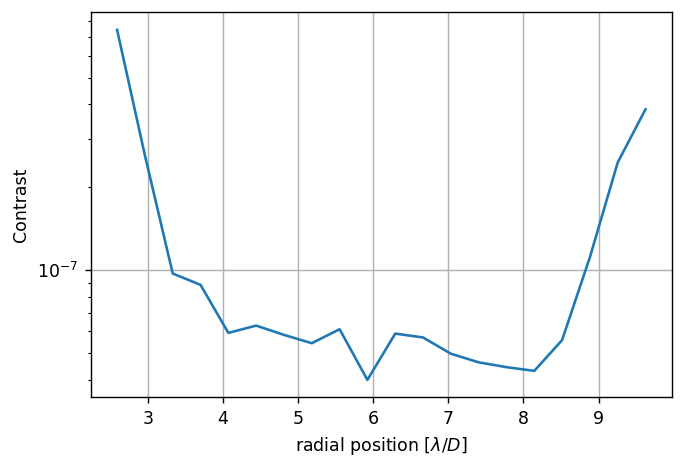

	Closed-loop iteration 2 / 5


(3608,)

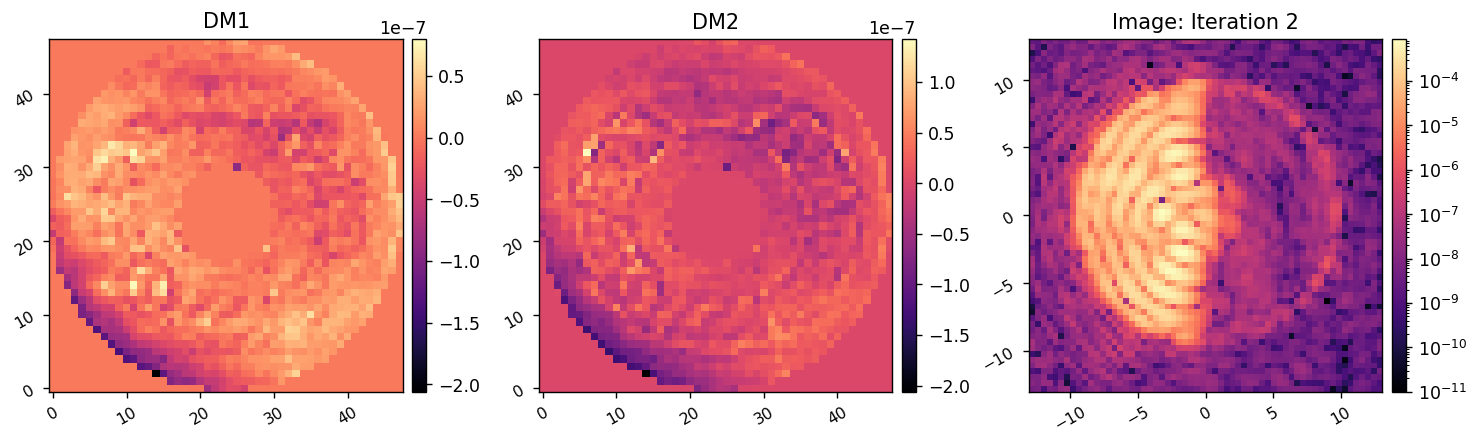

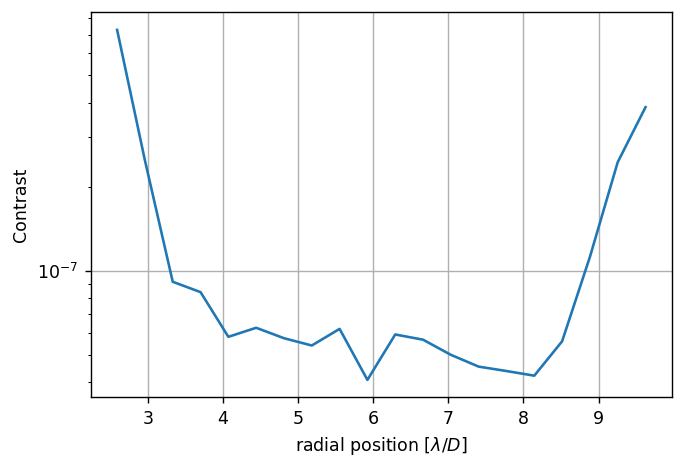

	Closed-loop iteration 3 / 5


(3608,)

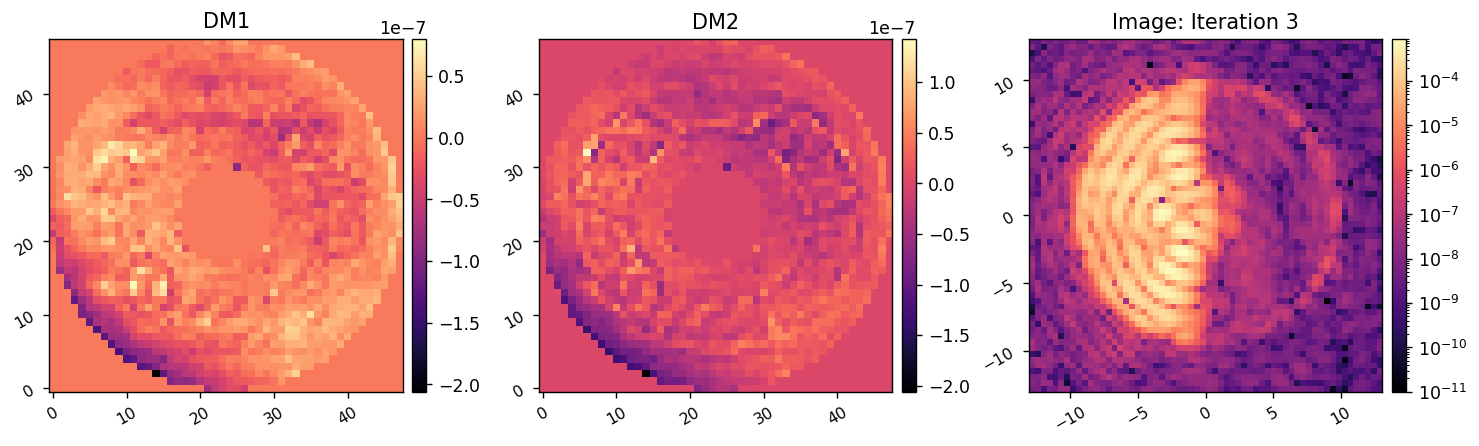

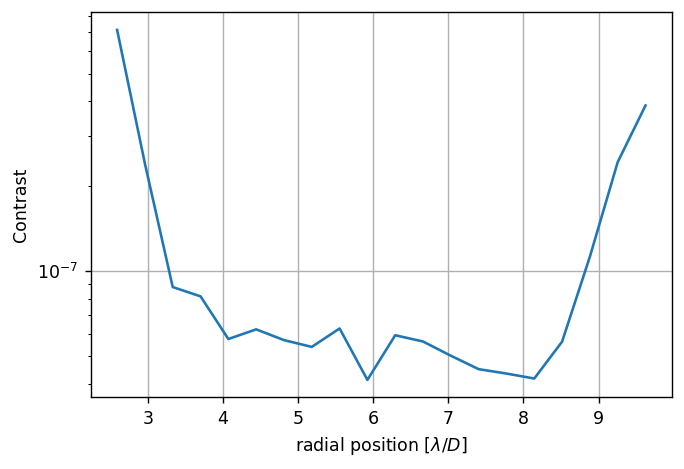

	Closed-loop iteration 4 / 5


(3608,)

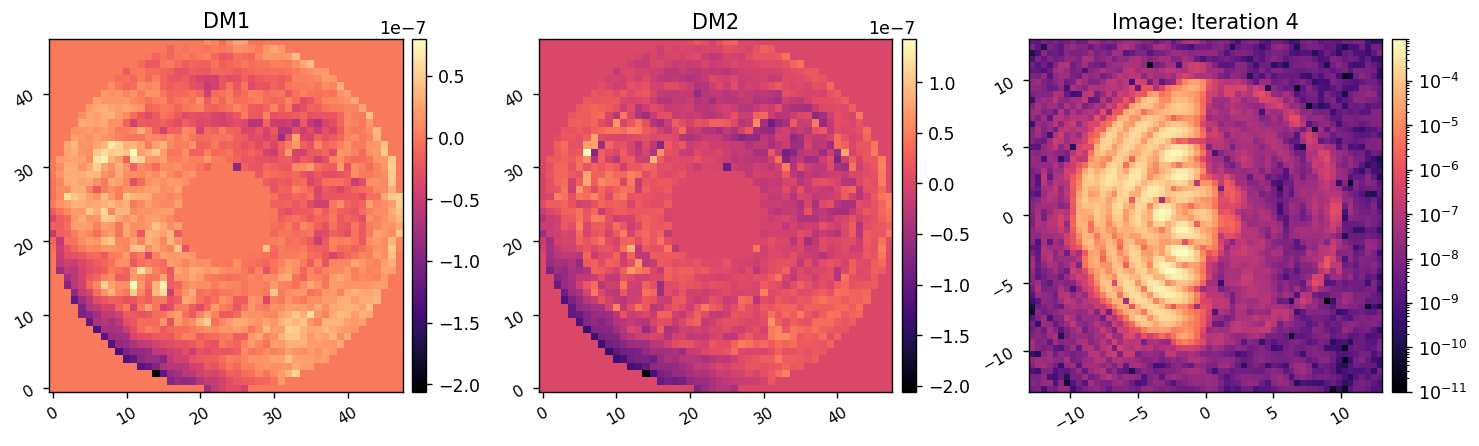

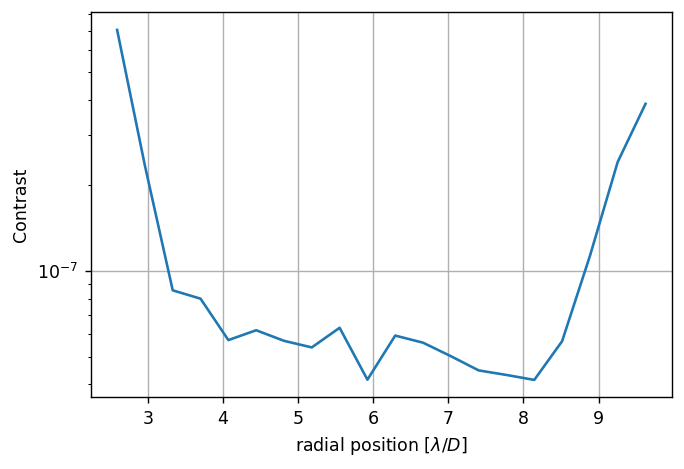

	Closed-loop iteration 5 / 5


(3608,)

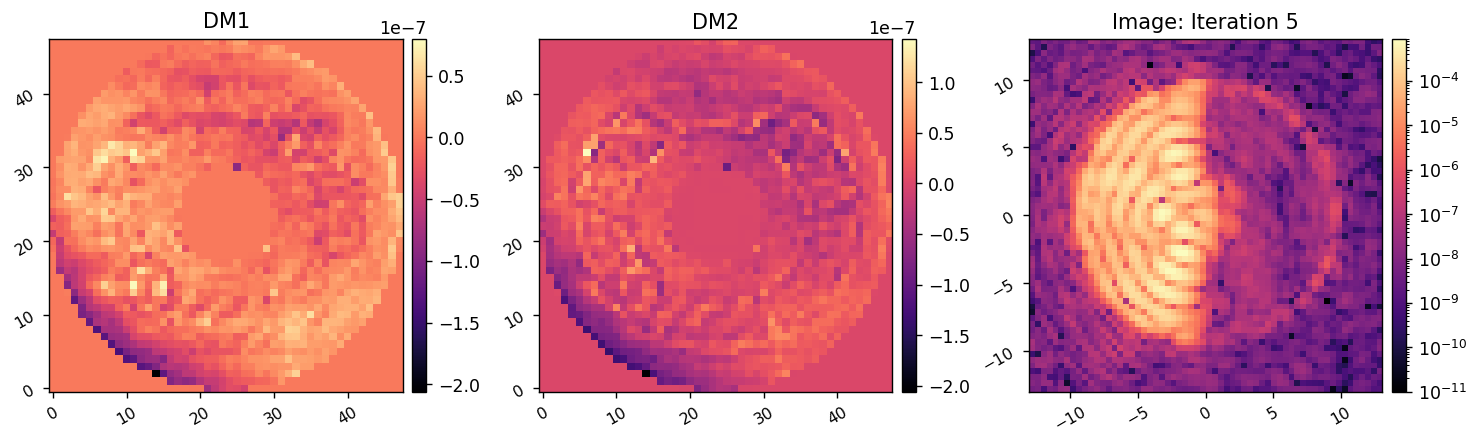

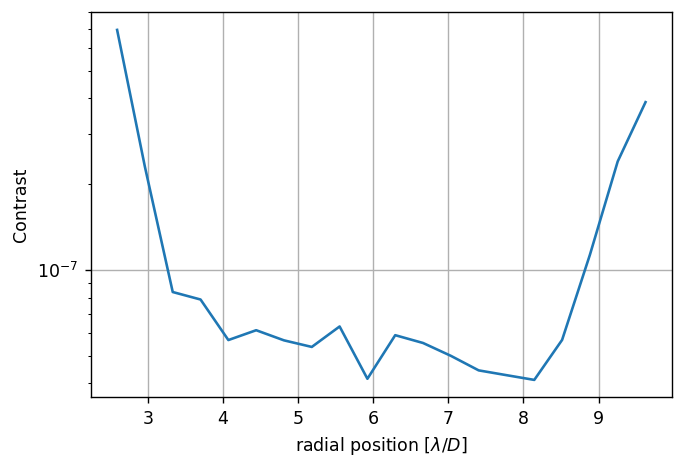

I-EFC loop completed in 12.404s.


In [128]:
reg_cond = 1e-2
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_2, weight_map, nprobes=len(probe_modes), rcond=reg_cond)

images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1436, 1436) (1436, 3608)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3608,)

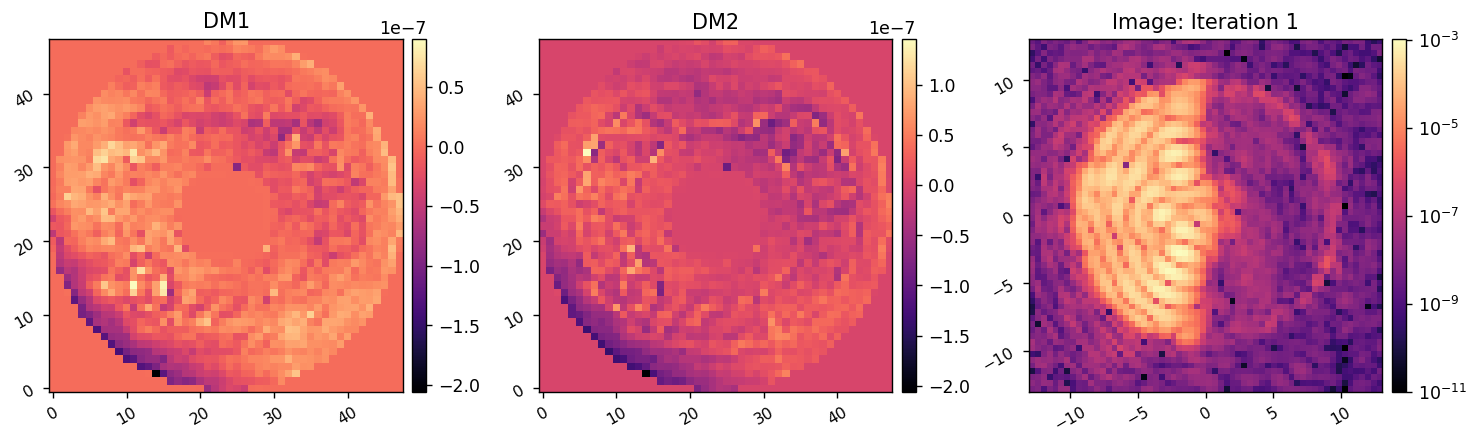

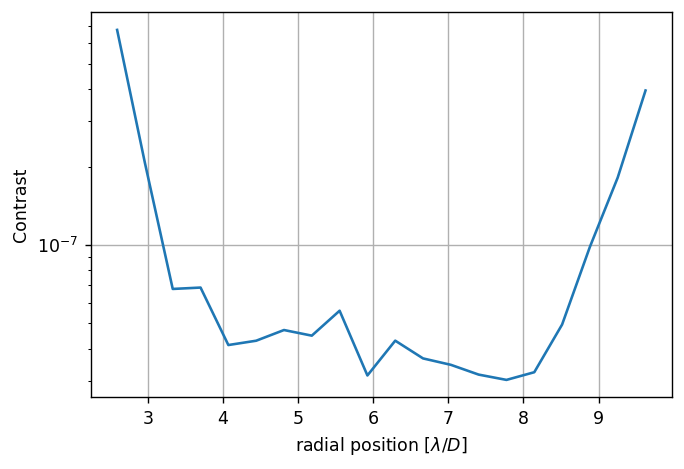

	Closed-loop iteration 2 / 5


(3608,)

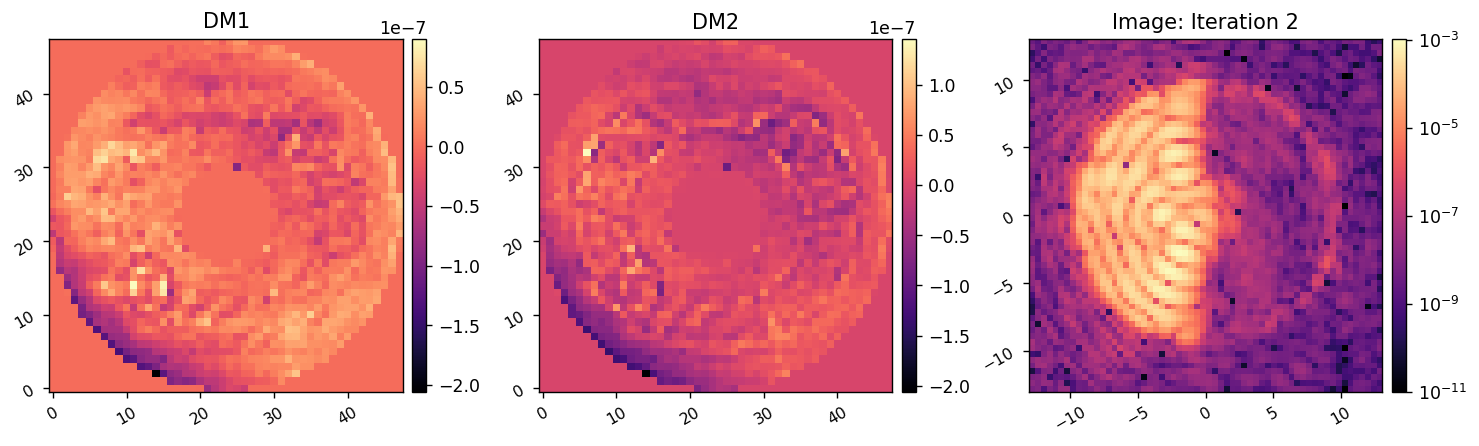

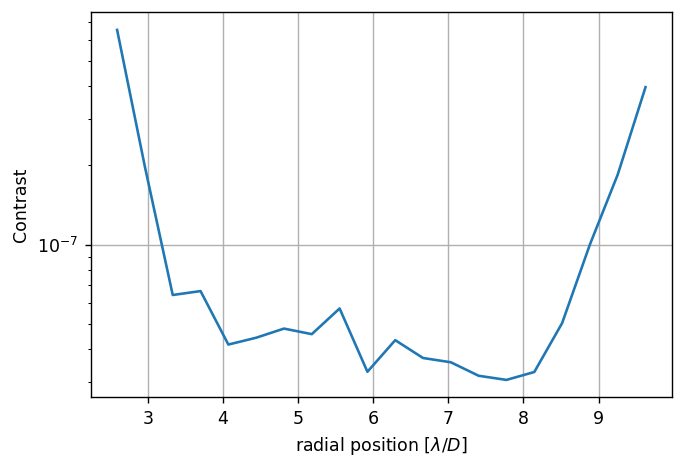

	Closed-loop iteration 3 / 5


(3608,)

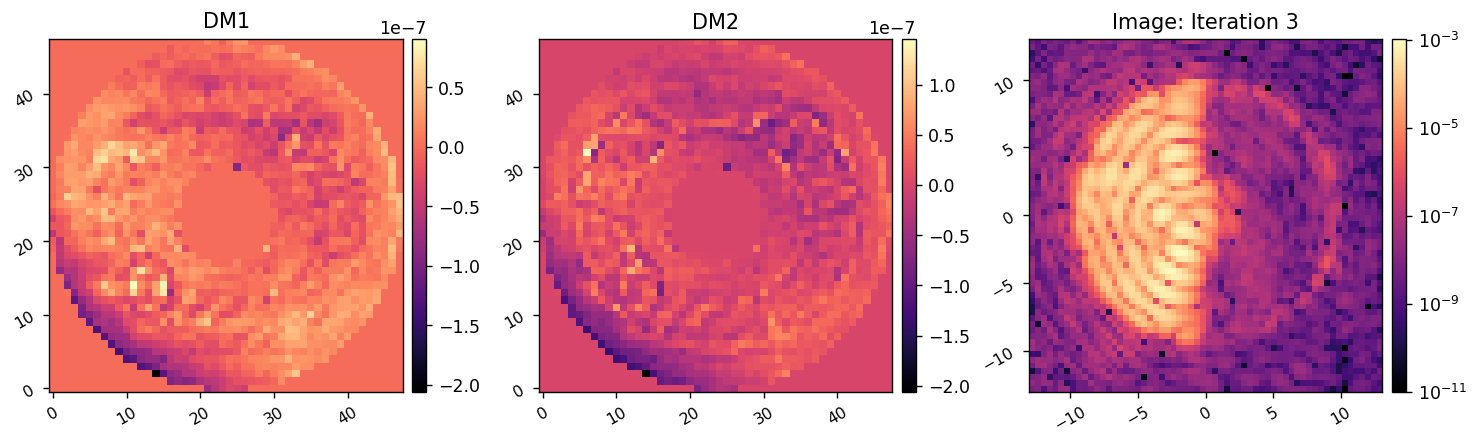

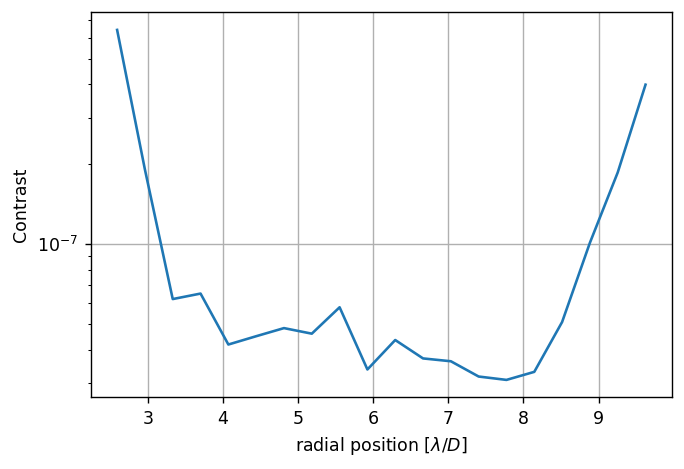

	Closed-loop iteration 4 / 5


(3608,)

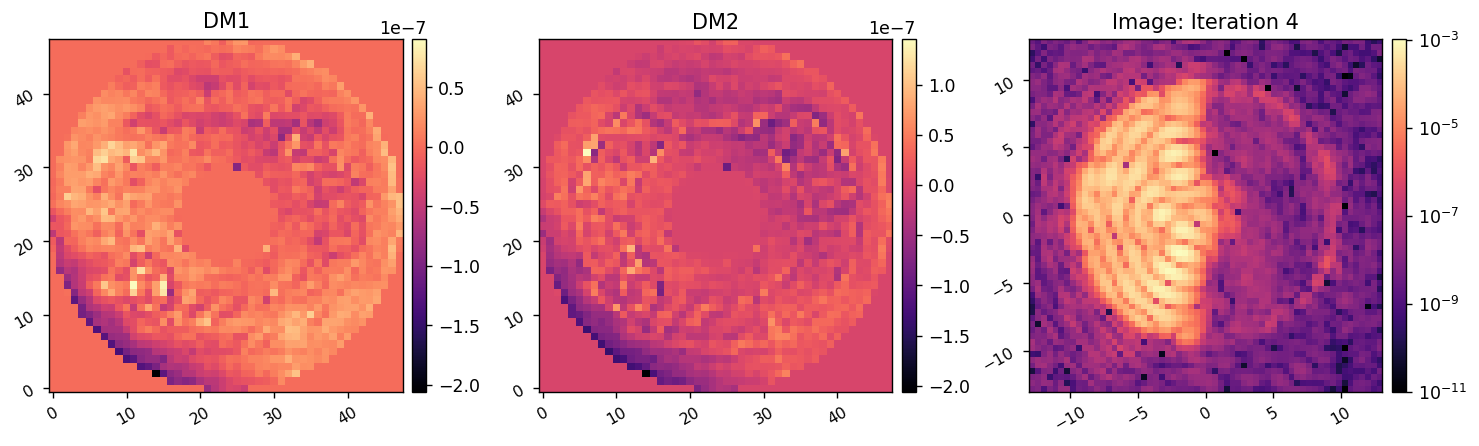

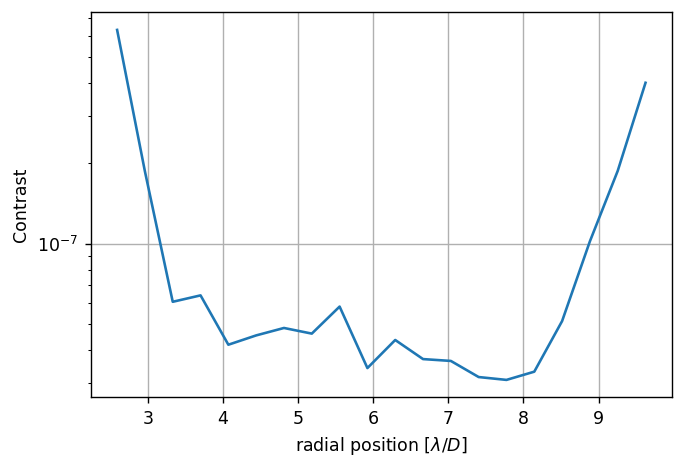

	Closed-loop iteration 5 / 5


(3608,)

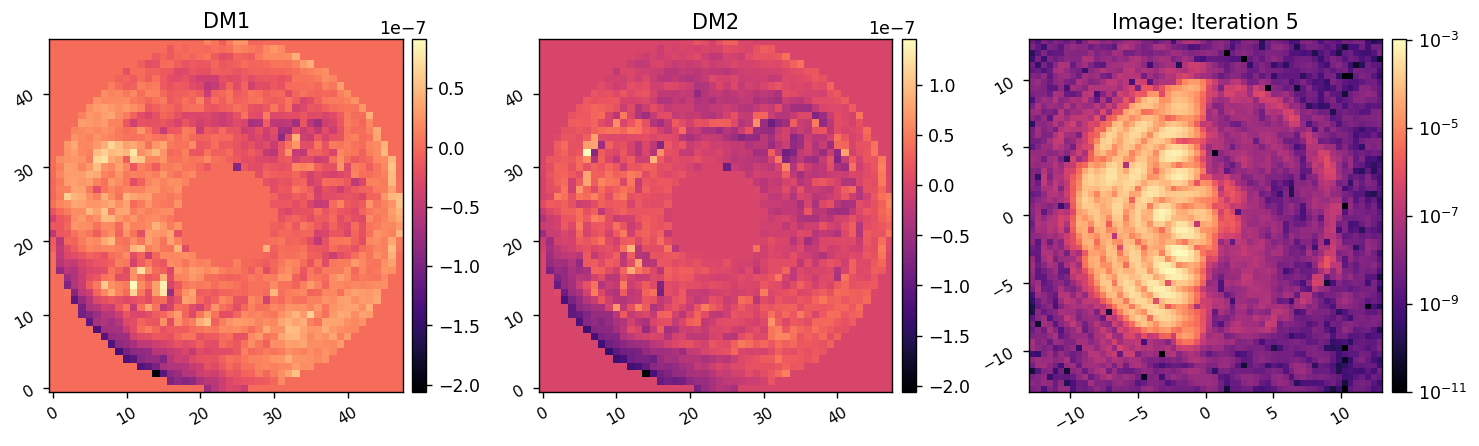

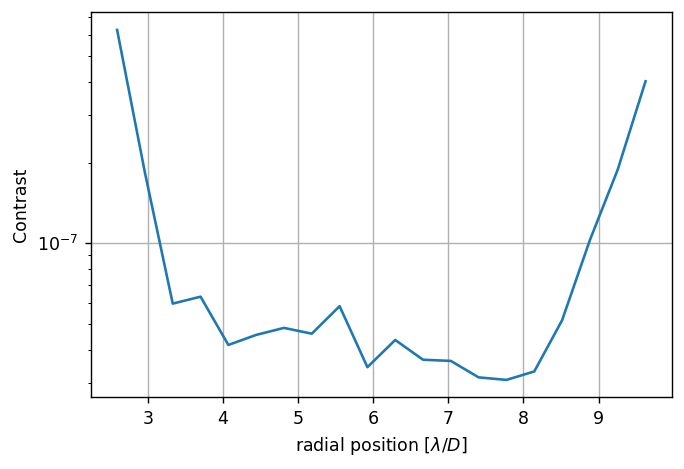

I-EFC loop completed in 11.581s.


In [132]:
reg_cond = 1e-2
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_2, weight_map, nprobes=len(probe_modes), rcond=reg_cond)

images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )